In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

In [179]:
#importacion de modelos
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
# Metricas
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, classification_report, confusion_matrix, f1_score, recall_score, precision_score

In [3]:
data = pd.read_csv('./data/diabetes_012_health_indicators_BRFSS2015.csv')

1. Flujo de Entrenamiento:
    * Cross Validation
    * Boostrapping
    * Whole Training Dataset

2. Test - Predict
3. Model EValuation
    * Graphs
    * Kruskal Wallis

## Esquema de entrenamiento

Para el entrenamiento de los diferentes modelos de clasificación a emplear, se seguirá el siguiente flujo de entrenamiento: 

1. **Se separan los datos en dos grupos**: Un bloque de datos será destinado para el entrenamiento de los modelos y otro para su evaluación, en una distribución de 75/25. Donde los datos que sean empleados para entrenar el modelo no serán los mismos que los empleados para poder evaluarlo, evitando de esta forma brindar conclusiones únicamente de datos ya previamente conocidos por los diferentes clasificadores. Por ende, ninguno de los datos presentes en el bloque de entrenamiento será empleado en el set de datos empleados para la evaluación de los modelos.
2. **Stratified K-Fold Cross Validation**: Se dividirán los datos de entrenamiento en diferentes particiones para poder entrenar el modelo, evitar una sobredependencia en los datos ya vistos y evitar de esta forma que los modelos se sobreajusten (*over-fitting*) a la información y tengan un muy buen rendimiento aparente en datos conocidos pero al momento de agregar o probar con nueva información este sea incapaz de procesarla o lo haga con resultados pobres.

    Se empleará la variente de Particiones Estratificadas o Stratified K-Fold, debido a que se esta trabajando con un conjunto de datos desbalanceado, donde además de ser múlticlase, las clases se encuentran distribuidas de forma desigual. En este caso, como se mencionó anteriormente, existe una sobre-representación por parte de los pacientes saludables en comparación con los diabéticos y los pre-diabéticos, y si no se toman medidas para poder ajustar los modelos a estas variaciones en las representaciones de los datos, se podría caer en casos donde las particiones de datos no contengan datos de alguna de las clases menos representadas, afectando el entrenamiento del modelo.

3. **Bootstrapping**: Acto seguido, se empleará Bootstrapping para entrenar el modelo en esta ocasión con valores los cuales pueden repetirse entre las diferentes muestras, dad la naturaleza del muestro con repetición, para validar que los resultados se mantienen consistentes al momento de realizar las clasificaciones, además de poder reducir el sesgo que podría producirse dado el caso de emplear particiones únicas.

4. **Entrenamiento completo en set de entrenamiento**: Finalmente, se entrenará el modelo en el grupo de entrenamiento completo, como última validación de métricas sin los cambios establecidos por la separación y estratificación o la repetición de datos, además de poder medir el tiempo completo que le tomaría al modelo entrenarse en el tamaño del set de datos.

De cada uno estos pasos se obtendran métricas del entrenamiento como referencia base para el contraste con el set de datos de evaluación del modelo. 

## Estandarización de datos

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Separando datos en observaciones y etiquetas
y = data["Diabetes_012"].values                # Etiquetas
X = data.drop(columns=["Diabetes_012"]).values # Observaciones

# Estandarizando datos
X = scaler.fit_transform(X)

### Separación de los datos en grupos de entrenamiento y prueba

In [5]:
from sklearn.model_selection import train_test_split

# Separando datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Cross-validation

A continuación se utilizará el proceso de cross-validation para evaluar cuál modelo tendrá un mejor rendimiento frente a datos desconocidos. Se tomará la decisión partir de la exactitud promedio que tenga cada modelo, es decir, qué tan frecuentemente cada modelo clasifica correctamente en los pliegues de validación.

Dado que los datos se encuentran desbalanceados: la clase de pacientes sanos está sobrerepresentada en comparación con los pacientes pre-diabéticos, y los diabéticos; se ha optado utilizar un muestreo estratificado, con el cual se preservará las proporciones de clases en cada pliegue de entrenamiento.

Para este caso se utilizará el iterador <a href="https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold">Stratified k-fold</a> de la librería scikit-learn utilizando los siguientes parámetros:
- *<b>n_splits</b>*: Indica el número k de veces que se separará los datos en diferentes "folds" siendo k-1 folds los utilizados para el entrenamiento y el último para validación. En otras palabras, se puede entrenar k veces al modelo utilizando en cada iteración diferentes sets de entrenamiento y de validación.
- *<b>shuffle</b>*: Indica si el set de datos se reordenará de manera aleatoria antes de realizar la separación. Esto es de utilidad para evitar que se genere un sesgo debido al orden de los datos.
- *<b>random_state</b>*: Para que los resultados sean reproducibles.

In [6]:
from sklearn.model_selection import StratifiedKFold, cross_validate

# Iterador para validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Función para obtener los scores de validación cruzada
def get_cv_scores(model, X, y, cv):
    # Lista de métricas de evaluación
    scoring = ['accuracy', 'f1_macro', 'recall_macro', 'roc_auc_ovr']

    results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True, error_score='raise')
    
    scores = {}
    # Mostrar resultados
    for metric in scoring:
        scores[metric] = results['test_' + metric]
    return scores

Además, se gráficara cada una de las métricas obtenidas, mostrando lo siguiente: 

* El eje *x* o u horizontal mostrará el rango ajustado a los valores obtenidos a lo largo de las pruebas con cada una de las particiones.
* El eje *y* o vertical mostrará la frecuencia con que dicho valor ha aparecido a lo largo del entrenamiento
* La linea que divide el gráfico de forma vertical marcará la media obtenida del indicador en cuestión, su valor también aparecerá en la leyenda del gráfico para facilitar su interpretación. 

In [7]:
# Función para graficar la distribución de los scores de exactitud
def graph_cv_scores(accuracy_scores, mean_score, metric_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(accuracy_scores, kde=True, bins=30, edgecolor='black', alpha=0.7)

    # Añadir líneas para los percentiles del 95% de IC
    plt.axvline(mean_score, color='black', linestyle='-', label=f'Mean: {mean_score:.4f}')
    
    # Etiquetas y título
    plt.title(f"Distribución de los Scores de {metric_name} (cross-validation)", fontsize=16)
    plt.xlabel(f"{metric_name}", fontsize=14)
    plt.ylabel("Frecuencia", fontsize=14)

    # Leyenda
    plt.legend()

    # Mostrar la gráfica
    plt.show()

In [8]:
# Funcion para graficar los resultados de las metricas en conjunto
def graph_cv_scores_multimetric(scores_dict, metric_names):
    """
    Args:
        scores_dict (dict): Un diccionario donde las claves son los nombres de las métricas y los valores son listas de scores.
        metric_names (list): Una lista de nombres de métricas que se graficarán.
    """
    num_metrics = len(metric_names)  # Número de métricas
    cols = 2  # Número de columnas en las subplots
    rows = (num_metrics + cols - 1) // cols  # Calcular filas necesarias

    # Crear la figura y los ejes
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)

    # Asegurar que `axes` sea un arreglo plano para facilitar el manejo
    axes = axes.flatten()

    # Iterar sobre cada métrica
    for idx, metric in enumerate(metric_names):
        if metric in scores_dict:
            accuracy_scores = scores_dict[metric]
            mean_score = np.mean(scores_dict[metric])
            
            # Crear el histograma
            sns.histplot(accuracy_scores, kde=True, bins=30, edgecolor='black', alpha=0.7, ax=axes[idx])

            # Añadir la línea del promedio
            axes[idx].axvline(mean_score, color='black', linestyle='-', label=f'Mean: {mean_score:.4f}')
            
            # Etiquetas y título
            axes[idx].set_title(f"Distribución de los Scores de {metric} (cross-validation)", fontsize=14)
            axes[idx].set_xlabel(f"{metric}", fontsize=12)
            axes[idx].set_ylabel("Frecuencia", fontsize=12)

            # Leyenda
            axes[idx].legend()
        else:
            # Si la métrica no está en los datos, mostrar un mensaje
            axes[idx].text(0.5, 0.5, f"No data for {metric}", fontsize=14, ha='center', va='center')
            axes[idx].set_title(metric)
            axes[idx].axis('off')

    # Apagar subplots extra si hay
    for i in range(len(metric_names), len(axes)):
        axes[i].axis('off')

    # Mostrar la gráfica
    plt.show()

### Métricas y generación de intervalos de confianza con bootstrap

A continuación se generan los intérvalos de confianza para cada modelo mediante el método de bootstrap. El método de bootstrap consiste en el remuestreo para estimar métricas en una población a partir de muestras con reemplazo del set de datos disponible.

#### ¿Cómo funciona?
1. De un set de datos grandes se crea una muestra con datos que pueden ser repetidos. Por ejemplo, de un set de 100 datos se toma una muestra de 80 datos, se escoge el dato en la posición i, sin embargo no se elimina de la fuente de datos por lo cual puede volver a ser escogido.
2. Una vez hecha la muestra, se obtiene la métrica de interés de esta. Por ejemplo, si es de interés obtener la media de la población, se obtendría la media de la muestra y se guarda.
3. Se repiten los pasos 1 y 2 hasta un número de iteraciones predefinido.
4. Una vez obtenidas las métricas para cada muestra, se saca el promedio de las métricas.

#### ¿Cómo se aplica en un modelo de aprendizaje automático?
Se repiten exactamente los mismos pasos mencionados anteriormente, sin embargo, se debe tomar en cuenta la siguiente variación: 
- Para el entrenamiento del modelo se utiliza la totalidad de los datos dentro de la muestra, sin embargo, para la evaluación del modelo se debe apartar otro set de datos conocido como out-of-bag u oob.

#### ¿Cómo calcular los intervalos de confianza?
Para obtener los intérvalos de confianza se define un nivel de confianza, por ejemplo: 95%; y se calculan los percentiles dentro de las métricas obtenidas a partir de bootstrap. Los percentiles obtenidos representan los límites inferior y superior del intérvalo. Por ejemplo, si se escoge un nivel de confianza del 95% y se obtienen los siguientes límites del intérvalo de confianza para la métrica de exactitud: [0.84, 0.87] se puede concluir que el 95% de las veces que se ejecute ese modelo tendrá una exactitud entre 84% y 87%.

#### Beneficios
- <b>Permite medir la estabilidad del modelo:</b> Cuando se realiza submuestreo bootstrap, se entrena y evalua el modelo en diferentes subconjuntos de datos. Esto permite ver cómo varía la métrica del modelo cuando se entrena en diferentes muestras de datos. Si el intervalo de confianza es estrecho, significa que la métrica del modelo es bastante estable, lo cual es deseable. Si es amplio, indica que el modelo puede estar siendo sensible a variaciones en los datos y que el rendimiento podría no ser consistente.
- <b>Justificación de selección de modelo:</b> Si el intervalo de confianza de un modelo es mucho más estrecho o más alto en comparación con otros modelos, se puede tener una base más sólida para justificar por qué ese modelo es el mejor.
- <b>Evaluación de la generalización del modelo:</b> El bootstrap permite evaluar cómo el modelo puede generalizar a datos no vistos, ya que se entrena con subconjuntos aleatorios de datos. Si el intervalo de confianza es relativamente pequeño y alto, indica que el modelo tiene un buen rendimiento general y puede generalizar bien, es decir, no está sobreajustado (overfitting).


**Dentro del desarrollo del proyecto, se empleará un intervalo de confianza del 95%**

In [9]:
# Función para obtener las métricas de evaluación y los límites del intérvalo de confianza
# Función para obtener las métricas de evaluación y los límites del intérvalo de confianza
def get_bootstrap_metrics_ci(n_iterations, sample_size, X, y, model, training=True):
    # Almacenar resultados de cada métrica
    metrics_results = {
        "accuracy": [],
        "sensitivity": [],  # Sensitivity = Recall para la clase positiva
        "auc": [],
        "f1": [],  # F1-score
    }
    
    indices = np.arange(X.shape[0])

    for i in range(n_iterations):
        np.random.seed(42 + i)
        
        # Selección bootstrap por índices
        bootstrap_indices = np.random.choice(indices, size=sample_size, replace=True)
        oob_indices = np.setdiff1d(indices, bootstrap_indices)

        # Conjunto bootstrap y OOB
        X_ = X[bootstrap_indices]
        y_ = y[bootstrap_indices]
        oob_x = X[oob_indices]
        oob_y = y[oob_indices]

        if training:
            # Entrenando modelo
            model.fit(X_, y_)
            

        # Predicciones
        y_pred = model.predict(oob_x)

        # Calcular métricas
        metrics_results["accuracy"].append(accuracy_score(oob_y, y_pred))
        metrics_results["sensitivity"].append(recall_score(oob_y, y_pred, average="macro"))
        metrics_results["f1"].append(f1_score(oob_y, y_pred, average="macro"))
        
        # Manejo de predict_proba para AUC multiclase
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(oob_x)  # Probabilidades para todas las clases
            
            # Calcular AUC multiclase
            try:
                auc_score = roc_auc_score(oob_y, y_pred_proba, multi_class="ovr", average="macro")
                metrics_results["auc"].append(auc_score)
            except ValueError as e:
                print(f"Error en AUC multiclase: {e}")
                metrics_results["auc"].append(None)
        else:
            y_pred_proba = None
            metrics_results["auc"].append(None)

    # Convertir las métricas a un DataFrame para facilidad de manejo
    metrics_df = pd.DataFrame(metrics_results)
    
    # Calcular intervalos de confianza para cada métrica
    ci_results = {}
    for metric in metrics_results.keys():
        ci_results[metric] = {
            "mean": np.mean(metrics_df[metric]),
            "lower_bound": np.percentile(metrics_df[metric].dropna(), 2.5),  # Excluye None
            "upper_bound": np.percentile(metrics_df[metric].dropna(), 97.5)
        }

    return metrics_df, ci_results

Además, se gráficara cada una de las métricas obtenidas, al igual que en Cross Validation siguiendo un esquema muy similar, mostrando lo siguiente: 

* El eje *x* o u horizontal mostrará el rango ajustado a los valores obtenidos a lo largo de las pruebas con cada una de las particiones.
* El eje *y* o vertical mostrará la frecuencia con que dicho valor ha aparecido a lo largo del entrenamiento
* La linea que divide el gráfico de forma vertical marcará la media obtenida del indicador en cuestión, su valor también aparecerá en la leyenda del gráfico para facilitar su interpretación. 

In [10]:
# Función para graficar la distribución de los scores de exactitud
def graph_bootstrap_ci(accuracy_scores, lower_bound, upper_bound, mean_score, metric_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(accuracy_scores, kde=True, bins=30, edgecolor='black', alpha=0.7)

    # Añadir líneas para los percentiles del 95% de IC
    plt.axvline(lower_bound, color='red', linestyle='--', label=f'2.5% Percentile: {lower_bound:.4f}')
    plt.axvline(upper_bound, color='green', linestyle='--', label=f'97.5% Percentile: {upper_bound:.4f}')
    plt.axvline(mean_score, color='black', linestyle='-', label=f'Mean: {mean_score:.4f}')
    
    # Etiquetas y título
    plt.title(f"Distribución de los Scores de {metric_name} (Bootstrap)", fontsize=16)
    plt.xlabel(f"{metric_name}", fontsize=14)
    plt.ylabel("Frecuencia", fontsize=14)

    # Leyenda
    plt.legend()

    # Mostrar la gráfica
    plt.show()

In [35]:
# TODO ADAPTAR LA FUNCION
def graph_bootstrap_ci_multimetric(scores_dict, metric_names,ci_values):
    num_metrics = len(metric_names)  # Número de métricas
    cols = 2  # Número de columnas en las subplots
    rows = (num_metrics + cols - 1) // cols  # Calcular filas necesarias

    # Crear la figura y los ejes
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)

    # Asegurar que `axes` sea un arreglo plano para facilitar el manejo
    axes = axes.flatten()

    # Iterar sobre cada métrica
    for idx, metric in enumerate(metric_names):
        if metric in scores_dict:
            accuracy_scores = scores_dict[metric]
            mean_score = ci_values[metric]['mean']
            lower_bound = ci_values[metric]['lower_bound']
            upper_bound = ci_values[metric]['upper_bound']
            
            
            # Crear el histograma
            sns.histplot(accuracy_scores, kde=True, bins=30, edgecolor='black', alpha=0.7, ax=axes[idx])

            # Añadir la línea del promedio
            axes[idx].axvline(mean_score, color='black', linestyle='-', label=f'Mean: {mean_score:.4f}')
            # Añadir líneas para los percentiles del 95% de IC
            axes[idx].axvline(lower_bound, color='red', linestyle='--', label=f'2.5% Percentile: {lower_bound:.4f}')
            axes[idx].axvline(upper_bound, color='green', linestyle='--', label=f'97.5% Percentile: {upper_bound:.4f}')
            
            # Etiquetas y título
            axes[idx].set_title(f"Distribución de los Scores de {metric} (Bootstrapping)", fontsize=14)
            axes[idx].set_xlabel(f"{metric}", fontsize=12)
            axes[idx].set_ylabel("Frecuencia", fontsize=12)

            # Leyenda
            axes[idx].legend()
        else:
            # Si la métrica no está en los datos, mostrar un mensaje
            axes[idx].text(0.5, 0.5, f"No data for {metric}", fontsize=14, ha='center', va='center')
            axes[idx].set_title(metric)
            axes[idx].axis('off')

    # Apagar subplots extra si hay
    for i in range(len(metric_names), len(axes)):
        axes[i].axis('off')

    # Mostrar la gráfica
    plt.show()

### Entrenamiento de los modelos

Indice: 
* Regresión Logística
* k nearest neighbors (KNN)
* Random Forest (RF)
* Decision Tree Classifier (DTC)
* Support Vector Machines
* Neural Network (NN) - Multilayer Perceptron
* LinearDiscriminantAnalysis (LDA)

#### Regresión Logística

In [73]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
scores = get_cv_scores(model=lr, X=X_train, y=y_train, cv=skf)

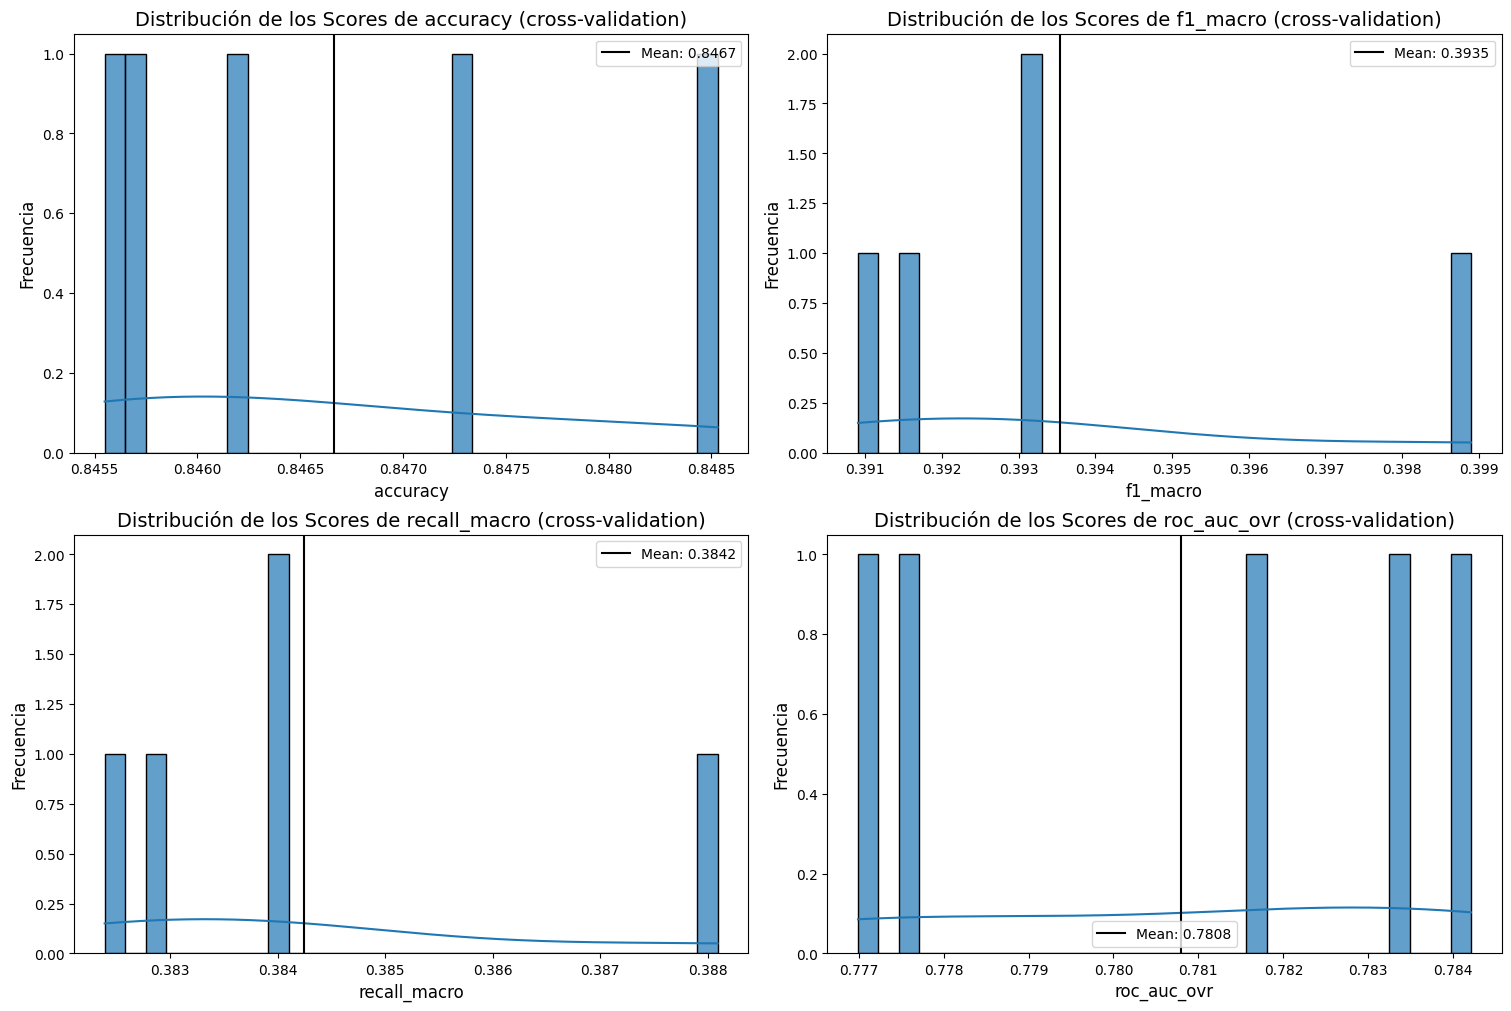

In [74]:
 graph_cv_scores_multimetric(scores,['accuracy', 'f1_macro', 'recall_macro', 'roc_auc_ovr'])

In [75]:
# Cambiar de 25 a 30 para entrega final 
n_iterations = 25
sample_size = int(X_train.shape[0] * 0.50)

lr = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
metrics_df, ci_results = get_bootstrap_metrics_ci(n_iterations, sample_size, X_train, y_train, lr)

In [76]:
print("Resultados de las métricas para cada muestra bootstrap:")
metrics_df.head()

Resultados de las métricas para cada muestra bootstrap:


,accuracy,sensitivity,auc,f1
0,0.845668,0.384483,0.778773,0.393753
1,0.846016,0.384337,0.781970,0.393556
2,0.847406,0.383119,0.781520,0.392203
3,0.846842,0.383343,0.781968,0.392373
4,0.846852,0.384873,0.781378,0.394297


In [77]:
print("Intervalos de confianza de las métricas:")
pd.DataFrame(ci_results)

Intervalos de confianza de las métricas:


,accuracy,sensitivity,auc,f1
mean,0.846633,0.384335,0.780466,0.393645
lower_bound,0.845646,0.381949,0.778917,0.390541
upper_bound,0.847495,0.386579,0.782177,0.396578


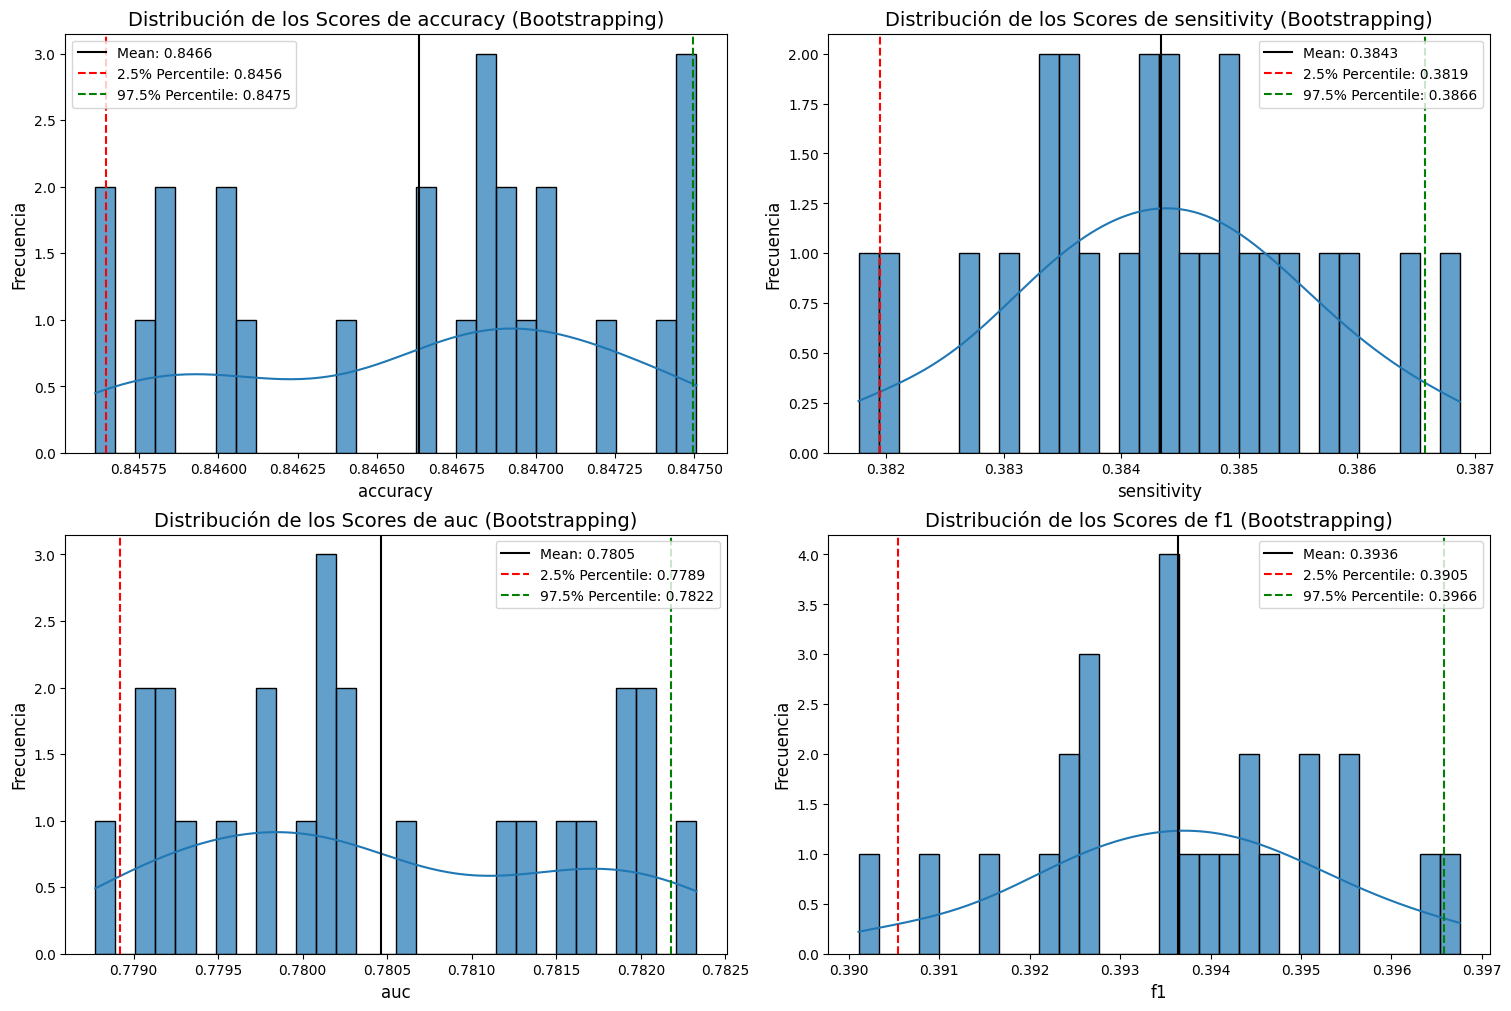

In [80]:
graph_bootstrap_ci_multimetric(metrics_df,['accuracy', 'sensitivity', 'auc', 'f1'],ci_results)

#### K nearest neighbors - KNN

In [79]:
knn = KNeighborsClassifier(n_neighbors=3)
scores = get_cv_scores(model=knn, X=X_train, y=y_train, cv=skf)

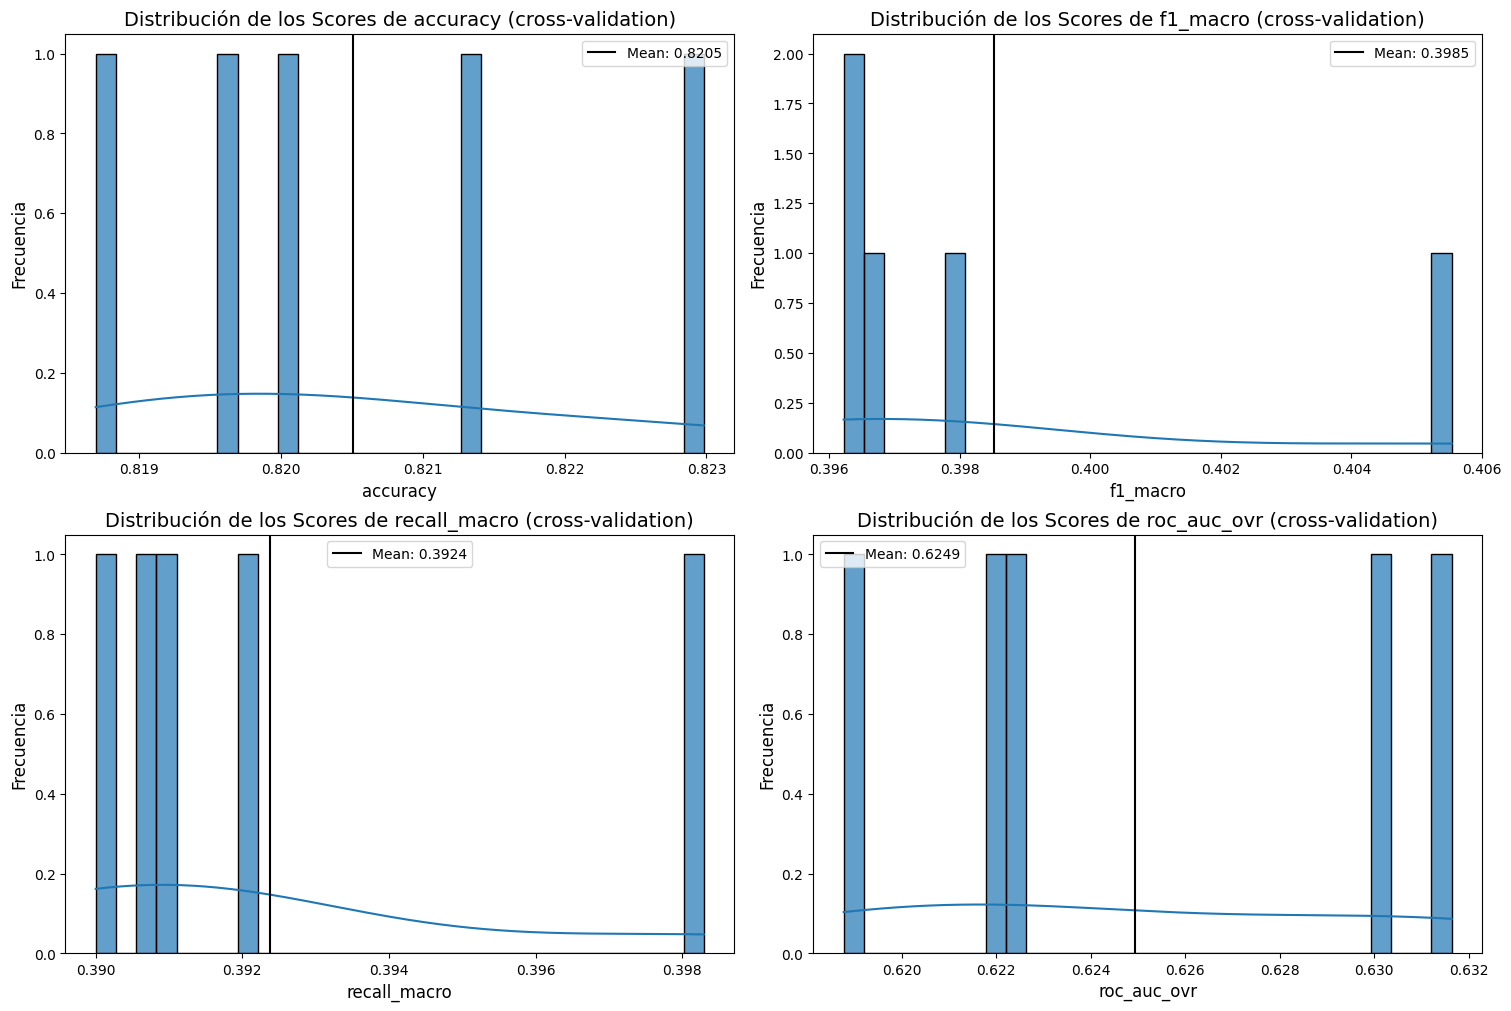

In [81]:
graph_cv_scores_multimetric(scores,['accuracy', 'f1_macro', 'recall_macro', 'roc_auc_ovr'])

In [82]:
metrics_df, ci_results = get_bootstrap_metrics_ci(n_iterations, sample_size, X_train, y_train, knn)

In [83]:
print("Resultados de las métricas para cada muestra bootstrap:")
metrics_df.head()

Resultados de las métricas para cada muestra bootstrap:


,accuracy,sensitivity,auc,f1
0,0.803056,0.392907,0.613242,0.398184
1,0.802990,0.393320,0.612475,0.398297
2,0.802915,0.390082,0.610866,0.394668
3,0.802643,0.393169,0.612699,0.397940
4,0.802667,0.393661,0.611576,0.398363


In [84]:
print("Intervalos de confianza de las métricas:")
pd.DataFrame(ci_results)

Intervalos de confianza de las métricas:


,accuracy,sensitivity,auc,f1
mean,0.802711,0.393159,0.612112,0.398147
lower_bound,0.801364,0.389977,0.609945,0.394662
upper_bound,0.804677,0.396529,0.614549,0.401917


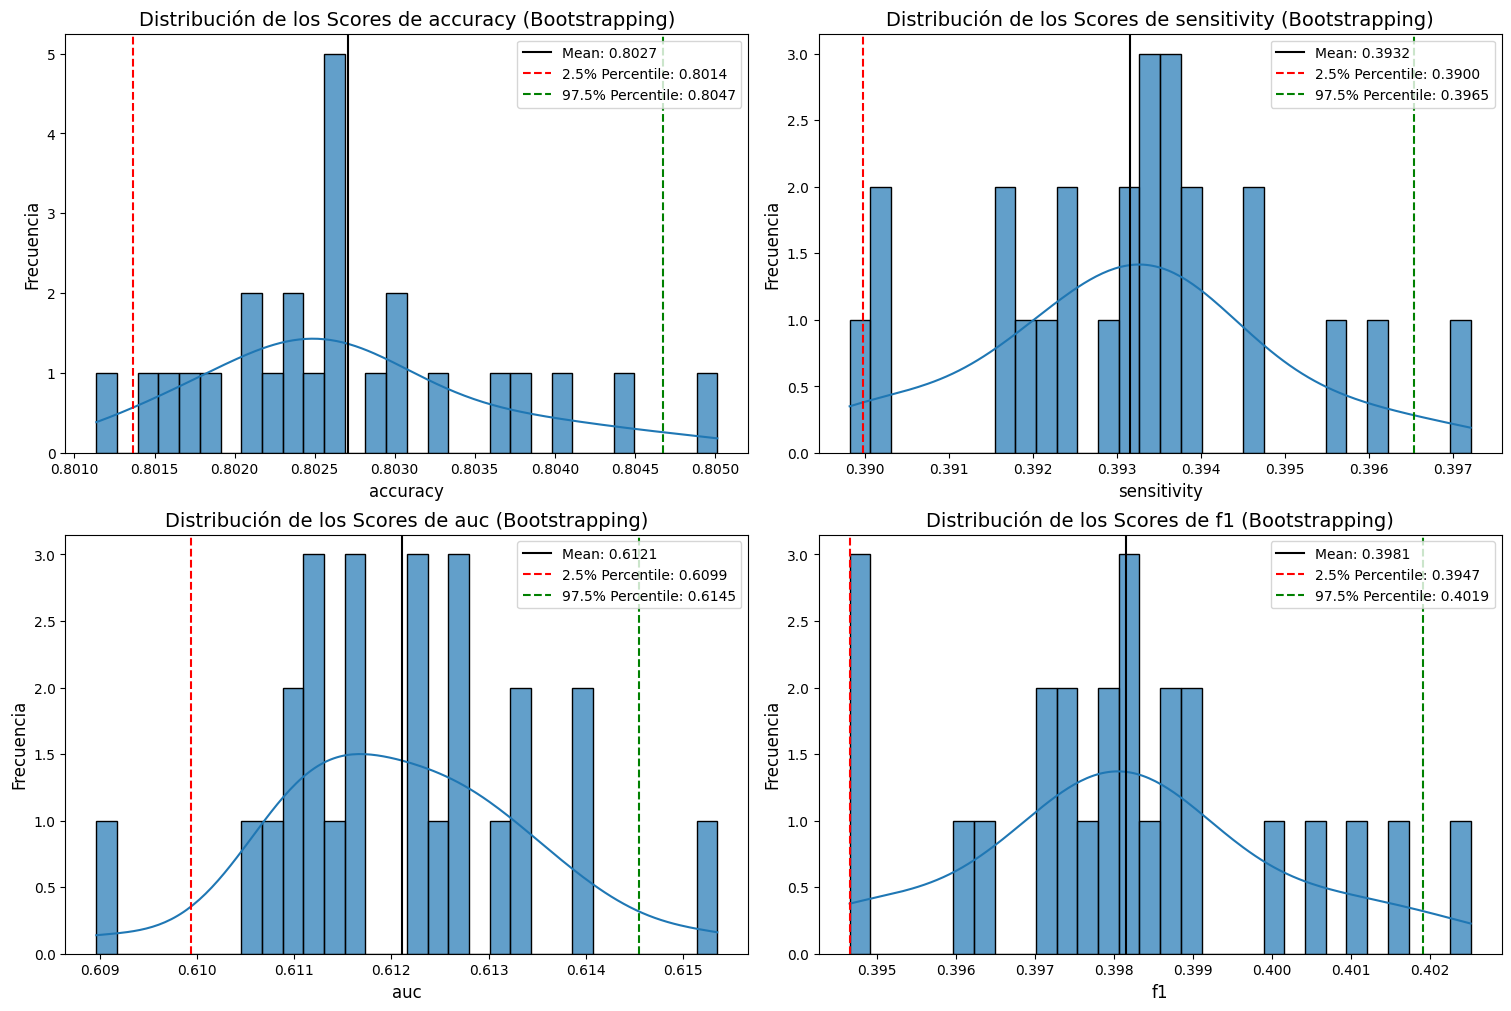

In [85]:
graph_bootstrap_ci_multimetric(metrics_df,['accuracy', 'sensitivity', 'auc', 'f1'],ci_results)

#### Random Forest

In [207]:
rf = RandomForestClassifier(max_depth=650,class_weight="balanced")

In [208]:
scores = get_cv_scores(model=rf, X=X_train, y=y_train, cv=skf)

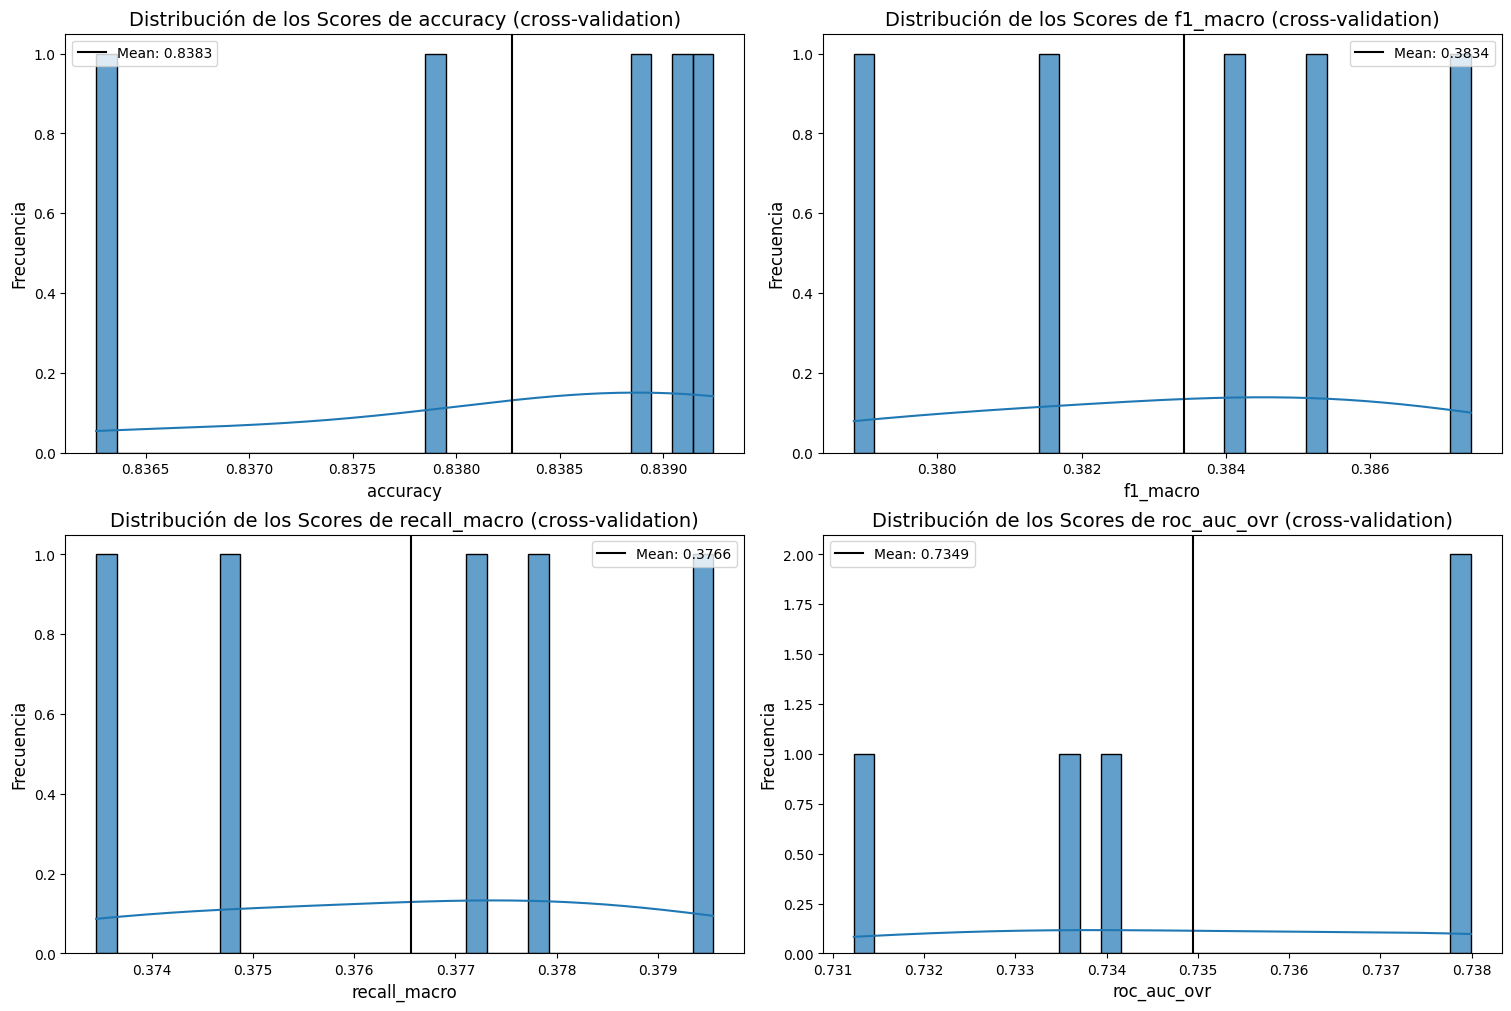

In [209]:
graph_cv_scores_multimetric(scores,['accuracy', 'f1_macro', 'recall_macro', 'roc_auc_ovr'])

In [210]:
metrics_df, ci_results = get_bootstrap_metrics_ci(n_iterations, sample_size, X_train, y_train, rf)

In [211]:
print("Resultados de las métricas para cada muestra bootstrap:")
metrics_df.head()

Resultados de las métricas para cada muestra bootstrap:


,accuracy,sensitivity,auc,f1
0,0.843654,0.368572,0.740245,0.371508
1,0.842792,0.367920,0.734043,0.370474
2,0.843373,0.368034,0.732890,0.370716
3,0.843186,0.369444,0.739056,0.372911
4,0.844462,0.371217,0.737038,0.375606


In [212]:
print("Intervalos de confianza de las métricas:")
pd.DataFrame(ci_results)

Intervalos de confianza de las métricas:


,accuracy,sensitivity,auc,f1
mean,0.843420,0.368803,0.736861,0.371876
lower_bound,0.842222,0.365657,0.732498,0.366997
upper_bound,0.844735,0.372821,0.740996,0.377762


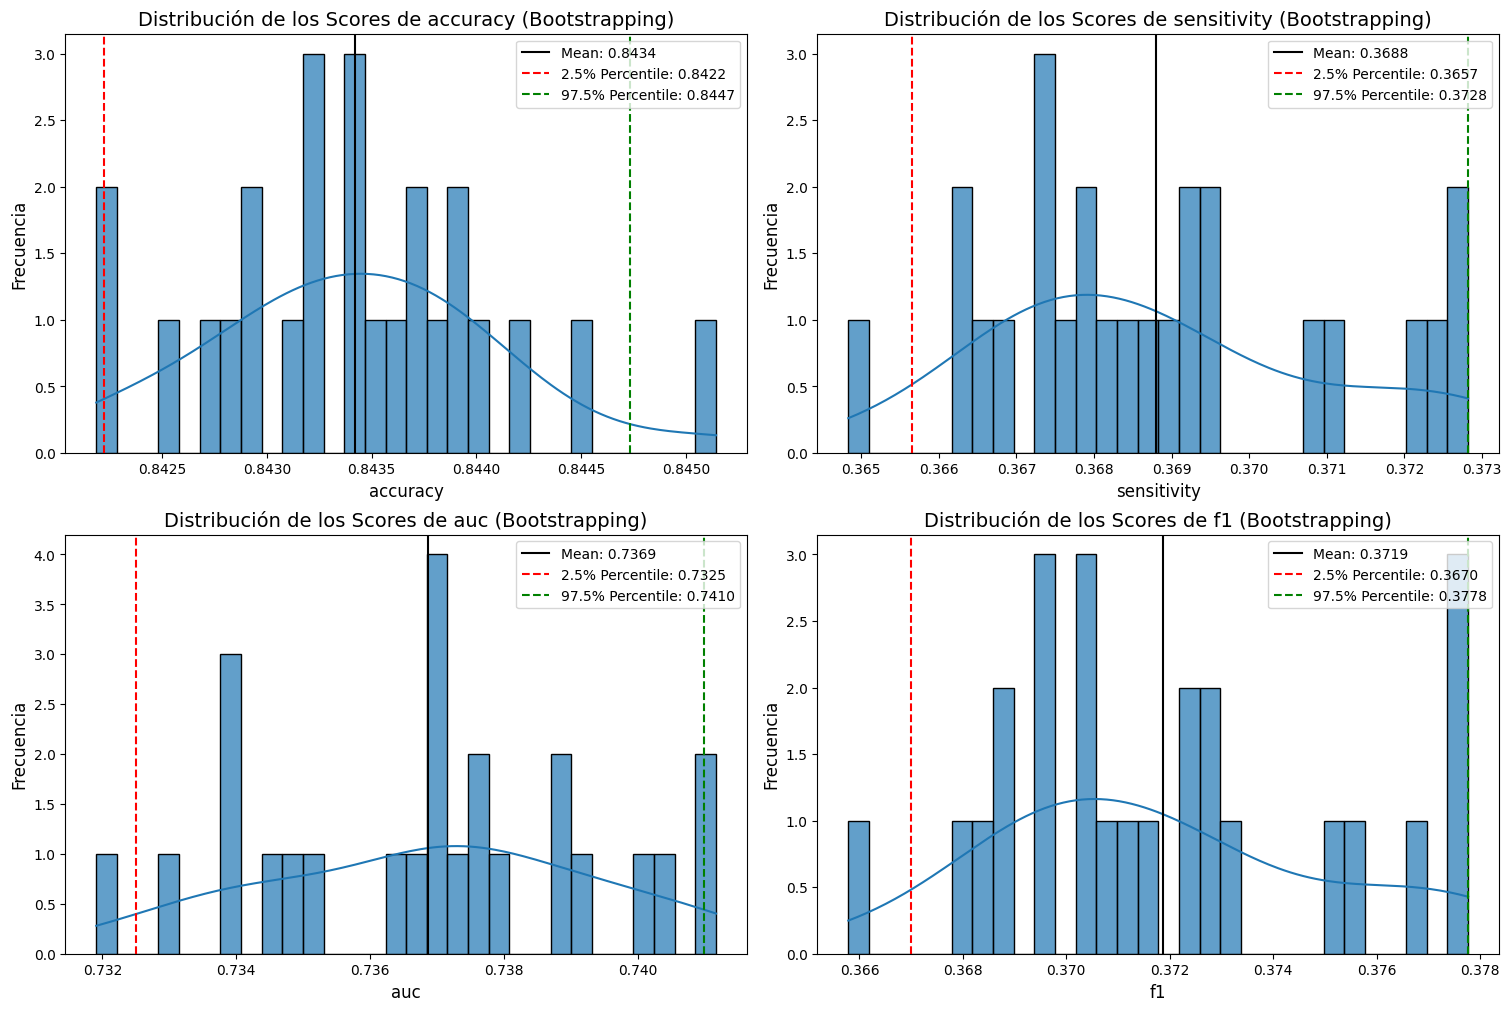

In [213]:
graph_bootstrap_ci_multimetric(metrics_df,['accuracy', 'sensitivity', 'auc', 'f1'],ci_results)

#### Decision Tree

In [168]:
dtc = DecisionTreeClassifier(max_depth=250,class_weight='balanced')
scores = get_cv_scores(model=dtc, X=X_train, y=y_train, cv=skf)

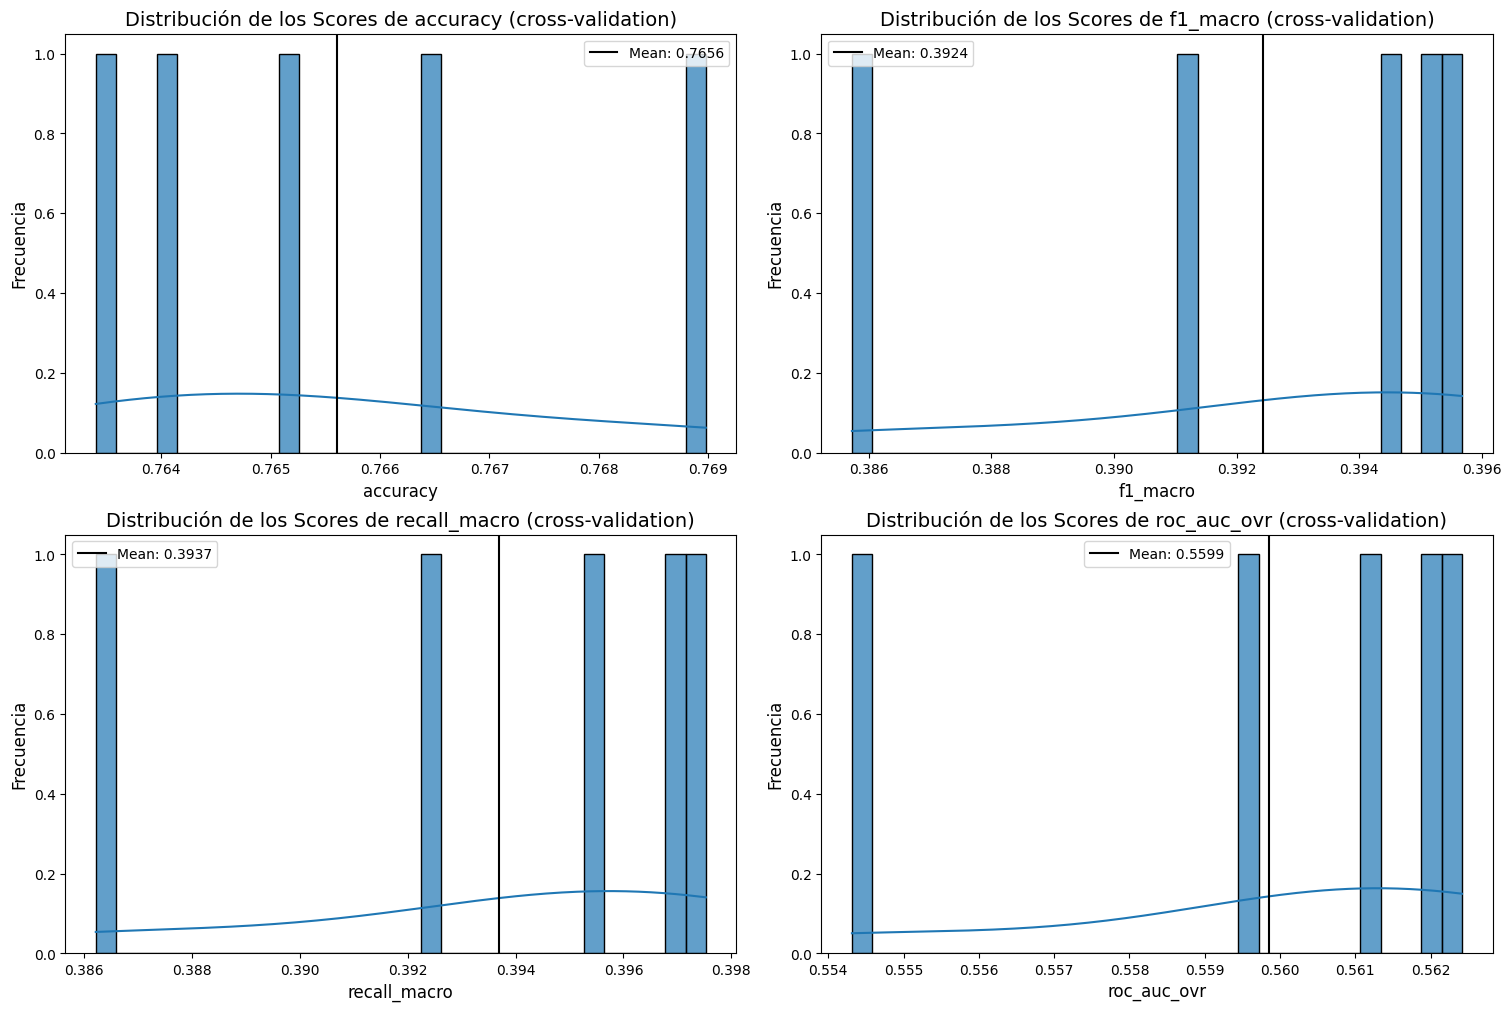

In [169]:
graph_cv_scores_multimetric(scores,['accuracy', 'f1_macro', 'recall_macro', 'roc_auc_ovr'])

In [170]:
metrics_df, ci_results = get_bootstrap_metrics_ci(n_iterations, sample_size, X_train, y_train, dtc)

In [171]:
print("Resultados de las métricas para cada muestra bootstrap:")
metrics_df.head()

Resultados de las métricas para cada muestra bootstrap:


,accuracy,sensitivity,auc,f1
0,0.768913,0.395151,0.560656,0.394616
1,0.771407,0.392663,0.558036,0.392771
2,0.769560,0.393008,0.558528,0.392663
3,0.768053,0.396718,0.561707,0.395562
4,0.767907,0.391911,0.558873,0.391508


In [172]:
print("Intervalos de confianza de las métricas:")
pd.DataFrame(ci_results)

Intervalos de confianza de las métricas:


,accuracy,sensitivity,auc,f1
mean,0.769365,0.393786,0.559185,0.393308
lower_bound,0.766939,0.390553,0.556144,0.390360
upper_bound,0.772531,0.397827,0.562495,0.396791


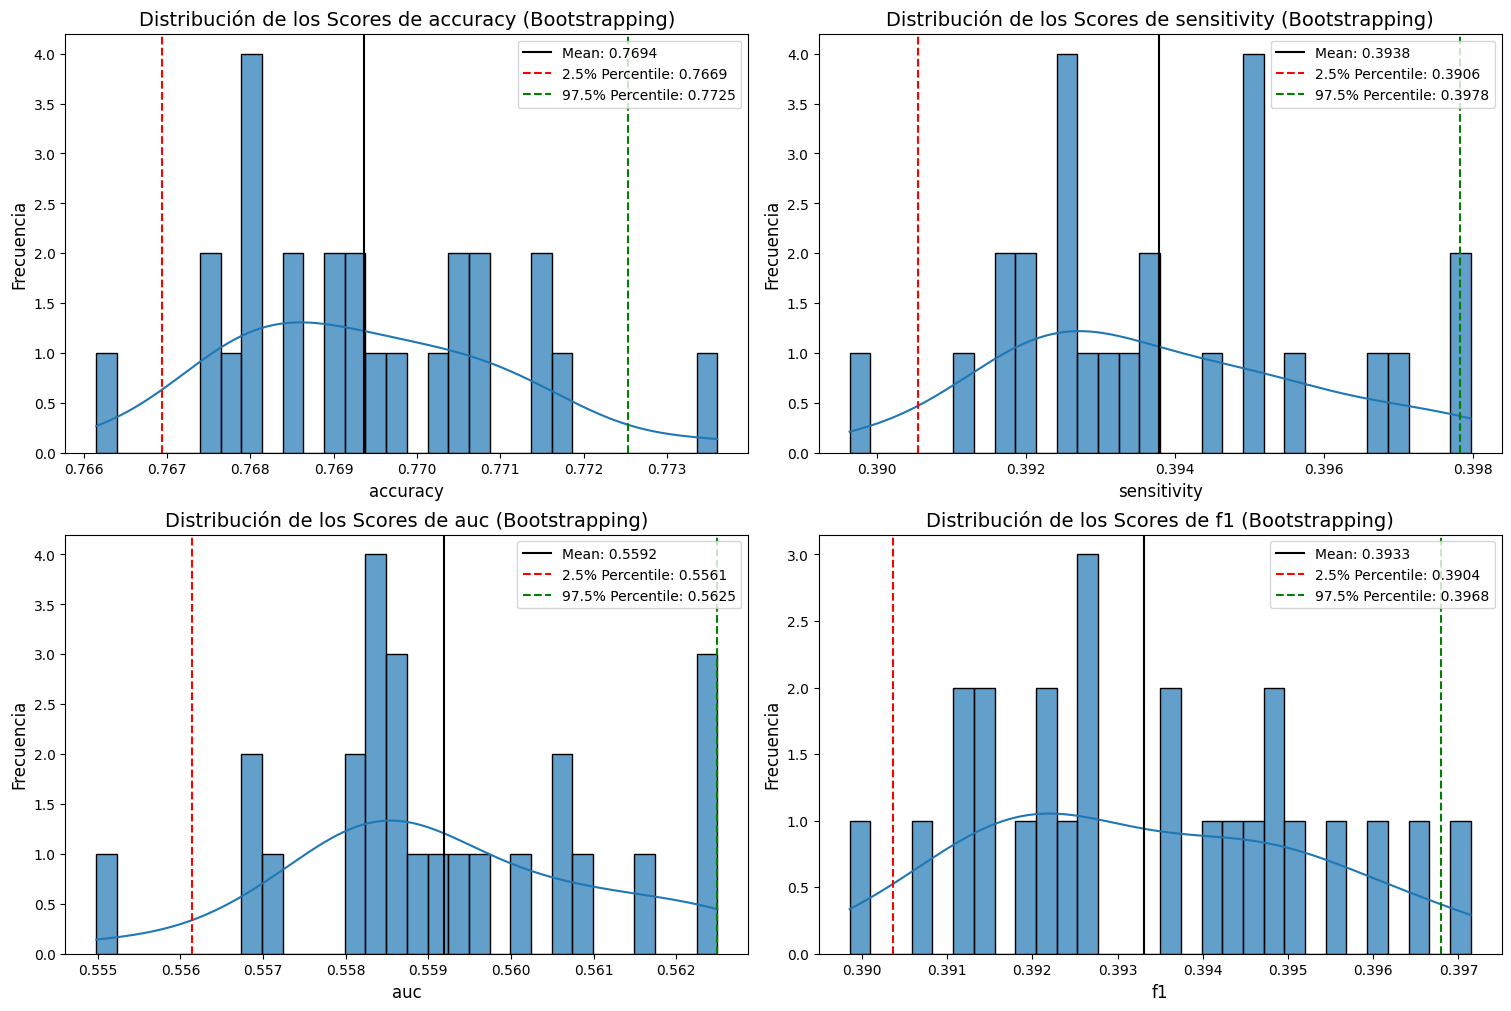

In [173]:
graph_bootstrap_ci_multimetric(metrics_df,['accuracy', 'sensitivity', 'auc', 'f1'],ci_results)

#### Support Vector Machines 

In [ ]:
svc =  SVC(kernel='linear', probability=True)
scores = get_cv_scores(model=svc, X=X_train, y=y_train, cv=skf)

In [ ]:
graph_cv_scores_multimetric(scores,['accuracy', 'f1_macro', 'recall_macro', 'roc_auc_ovr'])

In [ ]:
svc =  SVC(kernel='linear', probability=True)
metrics_df, ci_results = get_bootstrap_metrics_ci(n_iterations, sample_size, X_train, y_train, svc)

In [ ]:
print("Resultados de las métricas para cada muestra bootstrap:")
metrics_df.head()

In [ ]:
print("Intervalos de confianza de las métricas:")
pd.DataFrame(ci_results)

In [ ]:
graph_bootstrap_ci_multimetric(metrics_df,['accuracy', 'sensitivity', 'auc', 'f1'],ci_results)

#### Neural Network - Multilayer Perceptron

In [187]:
mp = MLPClassifier(max_iter=650)
scores = get_cv_scores(model=mp, X=X_train, y=y_train, cv=skf)

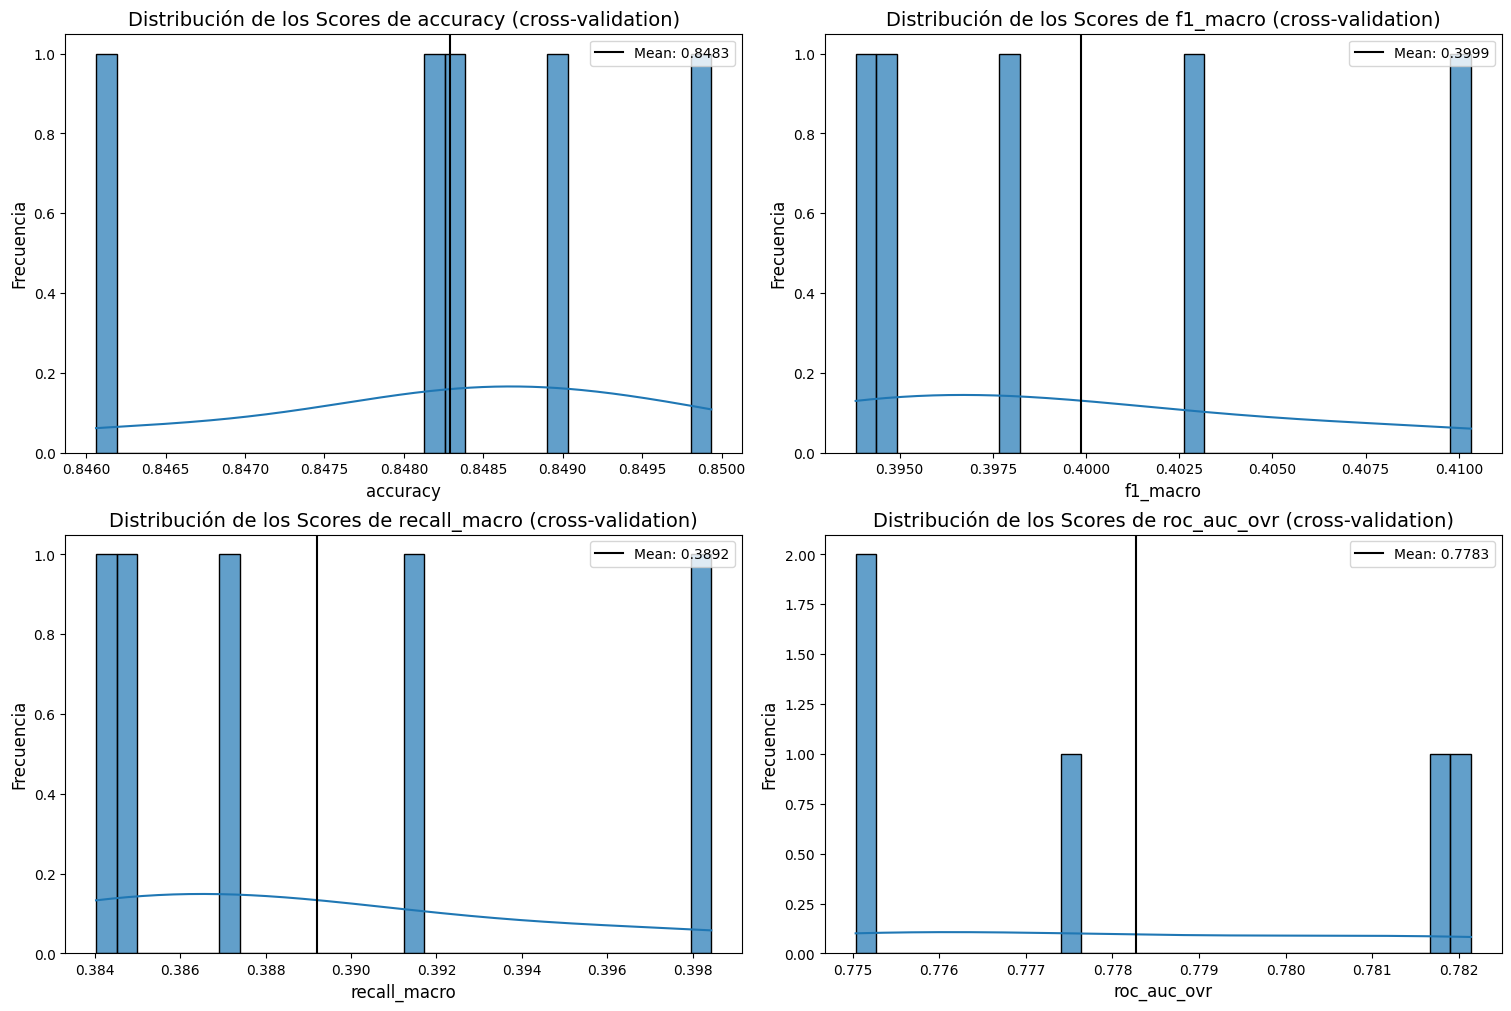

In [188]:
graph_cv_scores_multimetric(scores,['accuracy', 'f1_macro', 'recall_macro', 'roc_auc_ovr'])

In [189]:
metrics_df, ci_results = get_bootstrap_metrics_ci(n_iterations, sample_size, X_train, y_train, mp)

In [190]:
print("Resultados de las métricas para cada muestra bootstrap:")
metrics_df.head()

Resultados de las métricas para cada muestra bootstrap:


,accuracy,sensitivity,auc,f1
0,0.829033,0.403936,0.728625,0.410809
1,0.827983,0.401246,0.722208,0.409487
2,0.825214,0.400470,0.722540,0.408887
3,0.833628,0.395726,0.730341,0.406097
4,0.834997,0.392019,0.721159,0.401394


In [191]:
print("Intervalos de confianza de las métricas:")
pd.DataFrame(ci_results)

Intervalos de confianza de las métricas:


,accuracy,sensitivity,auc,f1
mean,0.829952,0.400527,0.726984,0.408909
lower_bound,0.824312,0.391241,0.713688,0.400025
upper_bound,0.835101,0.410850,0.736772,0.416739


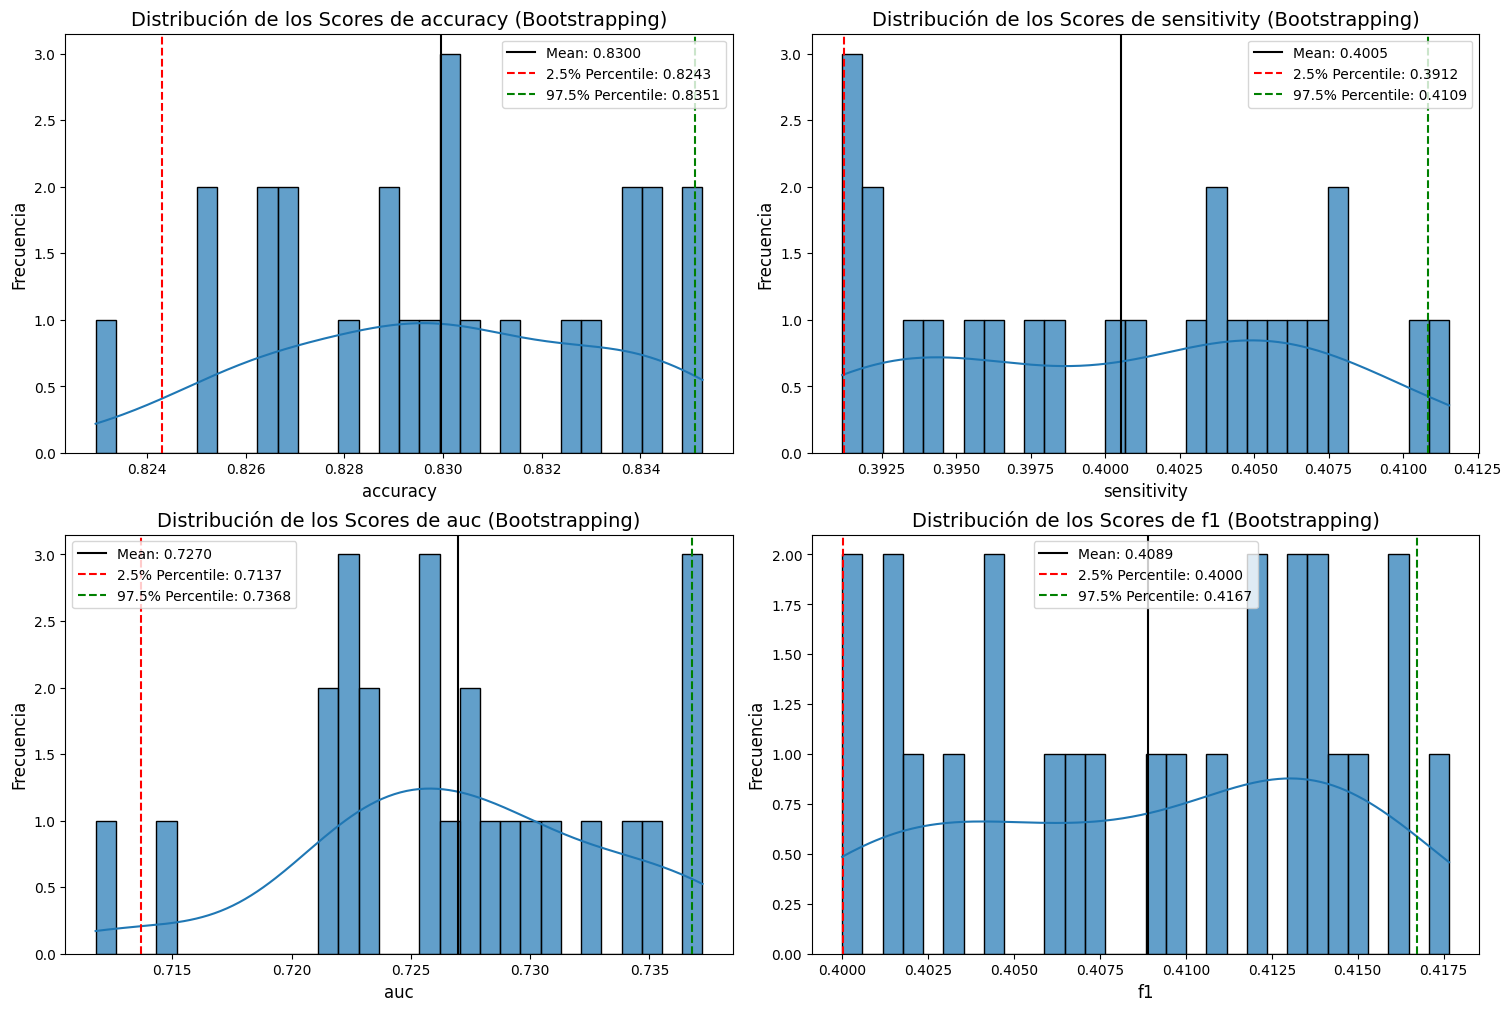

In [192]:
graph_bootstrap_ci_multimetric(metrics_df,['accuracy', 'sensitivity', 'auc', 'f1'],ci_results)

#### Linear Discriminant Analysis 

In [200]:
lda = LinearDiscriminantAnalysis()

In [201]:
scores = get_cv_scores(model=lda, X=X_train, y=y_train, cv=skf)

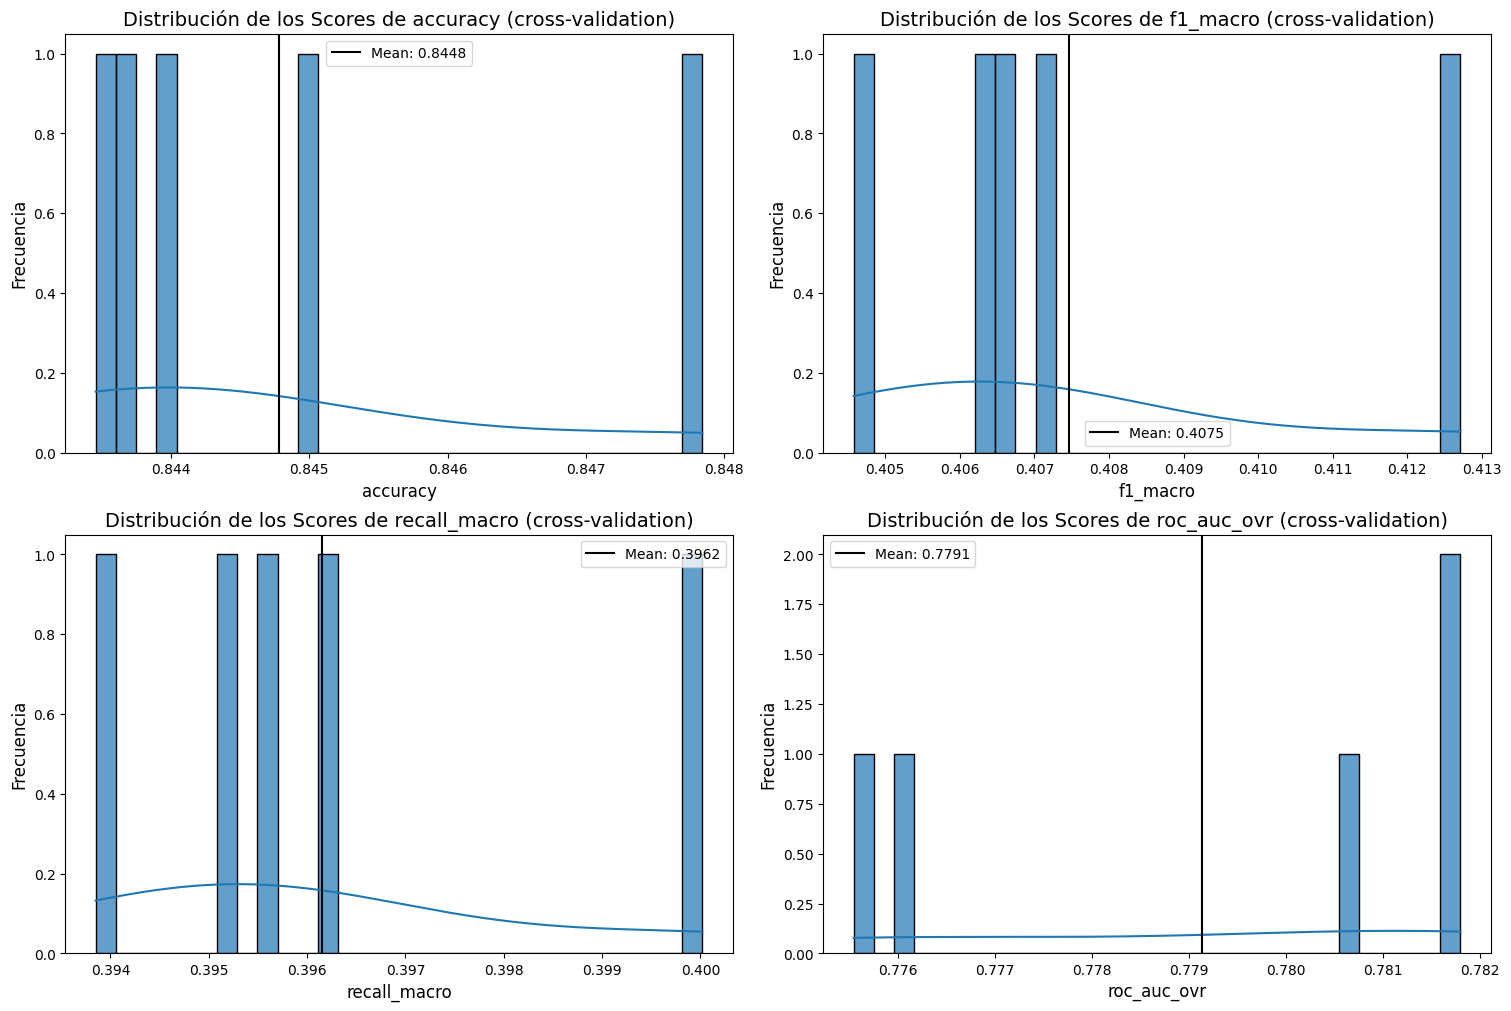

In [202]:
graph_cv_scores_multimetric(scores,['accuracy', 'f1_macro', 'recall_macro', 'roc_auc_ovr'])

In [203]:
metrics_df, ci_results = get_bootstrap_metrics_ci(n_iterations, sample_size, X_train, y_train, lda)

In [204]:
print("Resultados de las métricas para cada muestra bootstrap:")
metrics_df.head()

Resultados de las métricas para cada muestra bootstrap:


,accuracy,sensitivity,auc,f1
0,0.844078,0.397813,0.777079,0.409163
1,0.844086,0.396034,0.774259,0.407199
2,0.844825,0.395624,0.777767,0.406865
3,0.845352,0.396224,0.777562,0.407666
4,0.845121,0.394465,0.776560,0.405626


In [205]:
print("Intervalos de confianza de las métricas:")
pd.DataFrame(ci_results)

Intervalos de confianza de las métricas:


,accuracy,sensitivity,auc,f1
mean,0.844719,0.395857,0.776733,0.407082
lower_bound,0.843742,0.391598,0.774410,0.402262
upper_bound,0.845684,0.398640,0.778877,0.410091


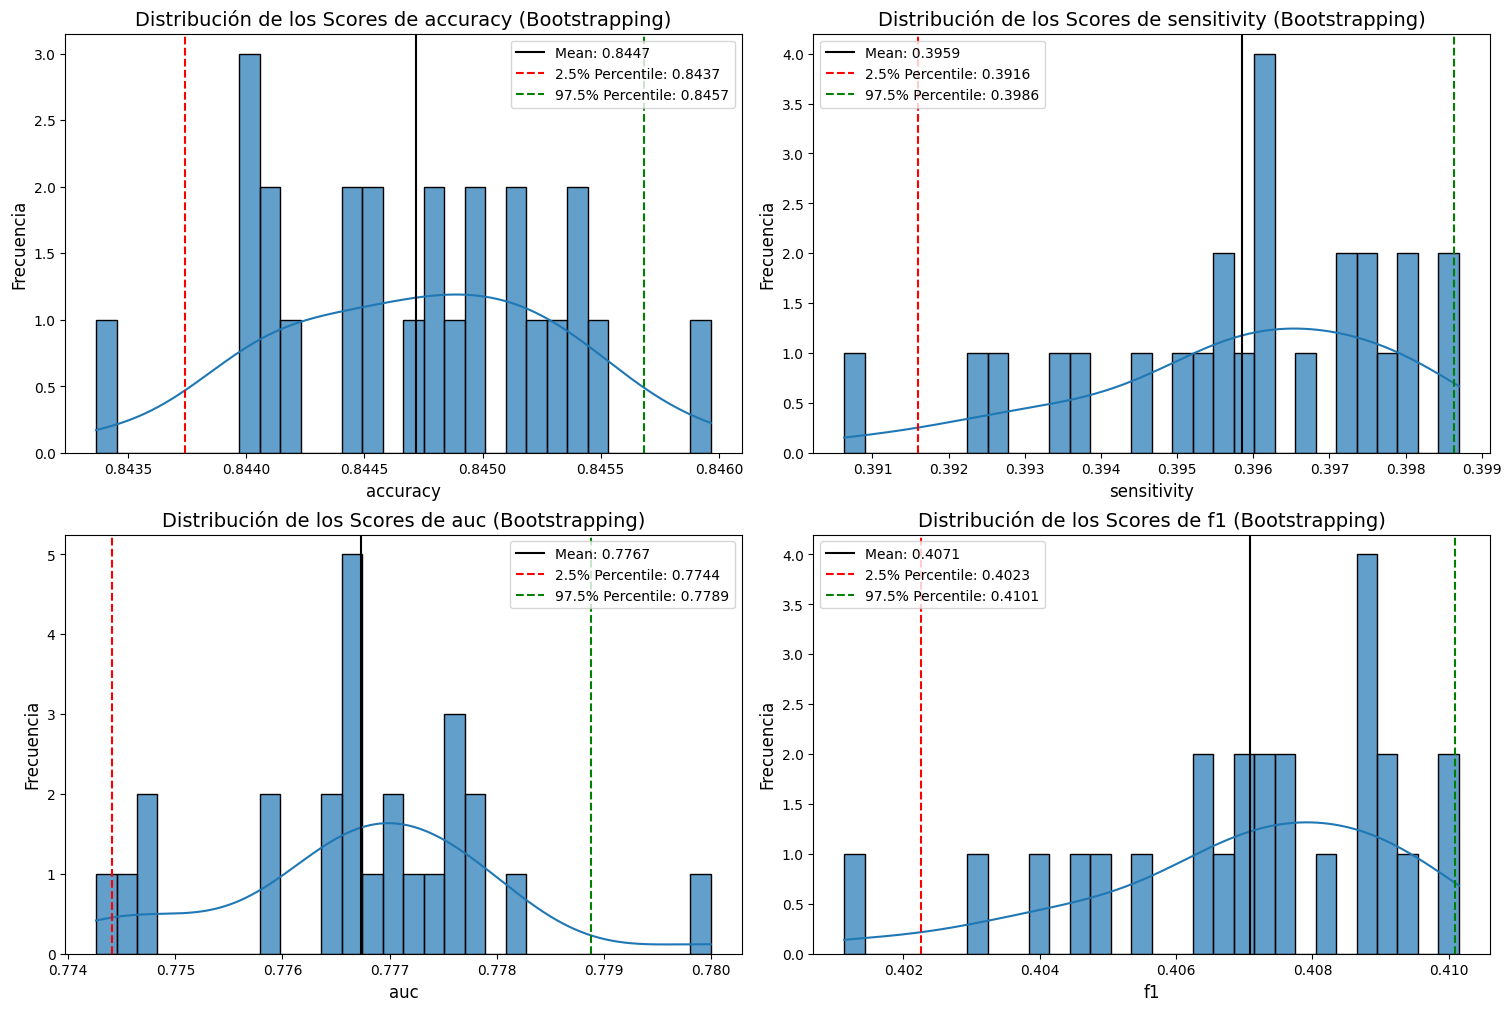

In [206]:
graph_bootstrap_ci_multimetric(metrics_df,['accuracy', 'sensitivity', 'auc', 'f1'],ci_results)

## Esquema de Prueba de Funcionamiento del modelo

Para poder evaluar el resultado final del entrenamiento de cada uno de los modelos y obtener métricas reales del funcionamiento del modelo, estos serán evaluados con los datos reservados para la prueba del modelo. 

Para poder obtener múltiples métricas y simular el uso de varios casos de datos desconocidos, el modelo de prueba se basará en la función de boostraping usada anteriormente, con la particularidad que el modelo no será entrenado en los datos, si no que simplemente se evaluarán predicciones del conjunto de datos empleados y se guardarán las métricas correspondientes a esa iteración, para luego poder realizar una comparación con el desempeño en el entrenamiento del modelo.  

In [100]:
models= {}

In [101]:
n_iterations = 25
sample_size = int(X_test.shape[0] * 0.50)

#### Logistic Classification

In [102]:
metrics_df, ci_results = get_bootstrap_metrics_ci(n_iterations, sample_size, X_test, y_test, lr,training=False)
models['Logistic Classification'] = {'metrics':metrics_df,'ci_results':ci_results} 

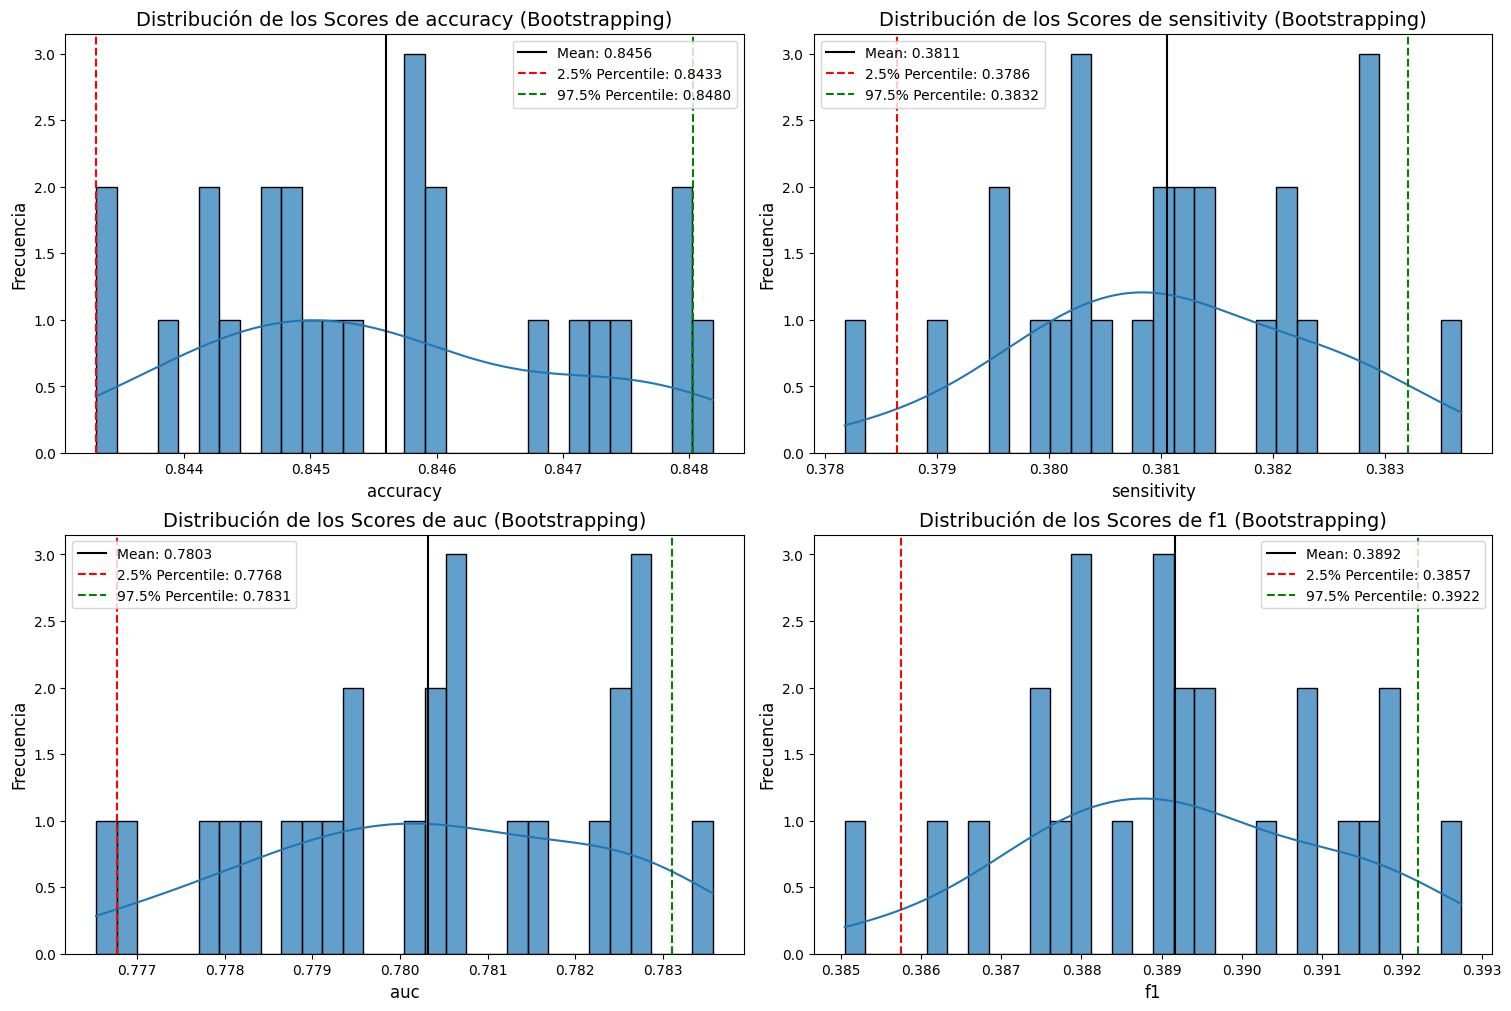

In [103]:
graph_bootstrap_ci_multimetric(models['Logistic Classification']['metrics'],['accuracy', 'sensitivity', 'auc', 'f1'],models['Logistic Classification']['ci_results'])

#### KNN

In [104]:
metrics_df, ci_results = get_bootstrap_metrics_ci(n_iterations, sample_size, X_test, y_test,knn ,training=False)
models['KNN'] = {'metrics':metrics_df,'ci_results':ci_results} 

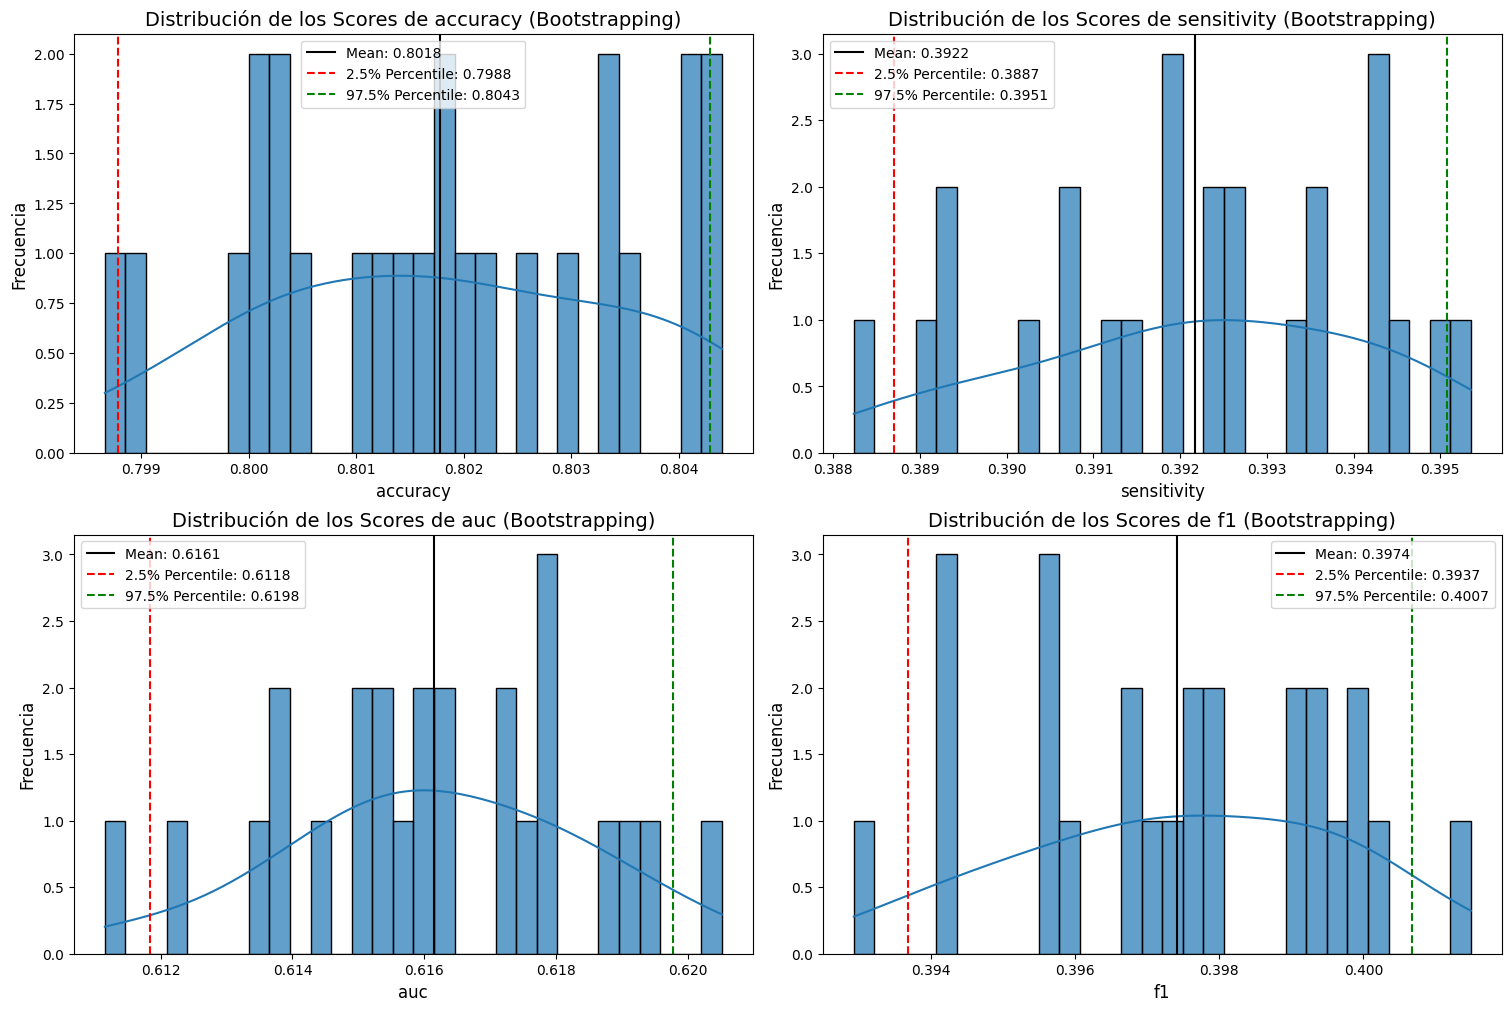

In [105]:
graph_bootstrap_ci_multimetric(models['KNN']['metrics'],['accuracy', 'sensitivity', 'auc', 'f1'],models['KNN']['ci_results'])

#### Random Forest

In [214]:
metrics_df, ci_results = get_bootstrap_metrics_ci(n_iterations, sample_size, X_test, y_test, rf ,training=False)
models['Random Forest'] = {'metrics':metrics_df,'ci_results':ci_results} 

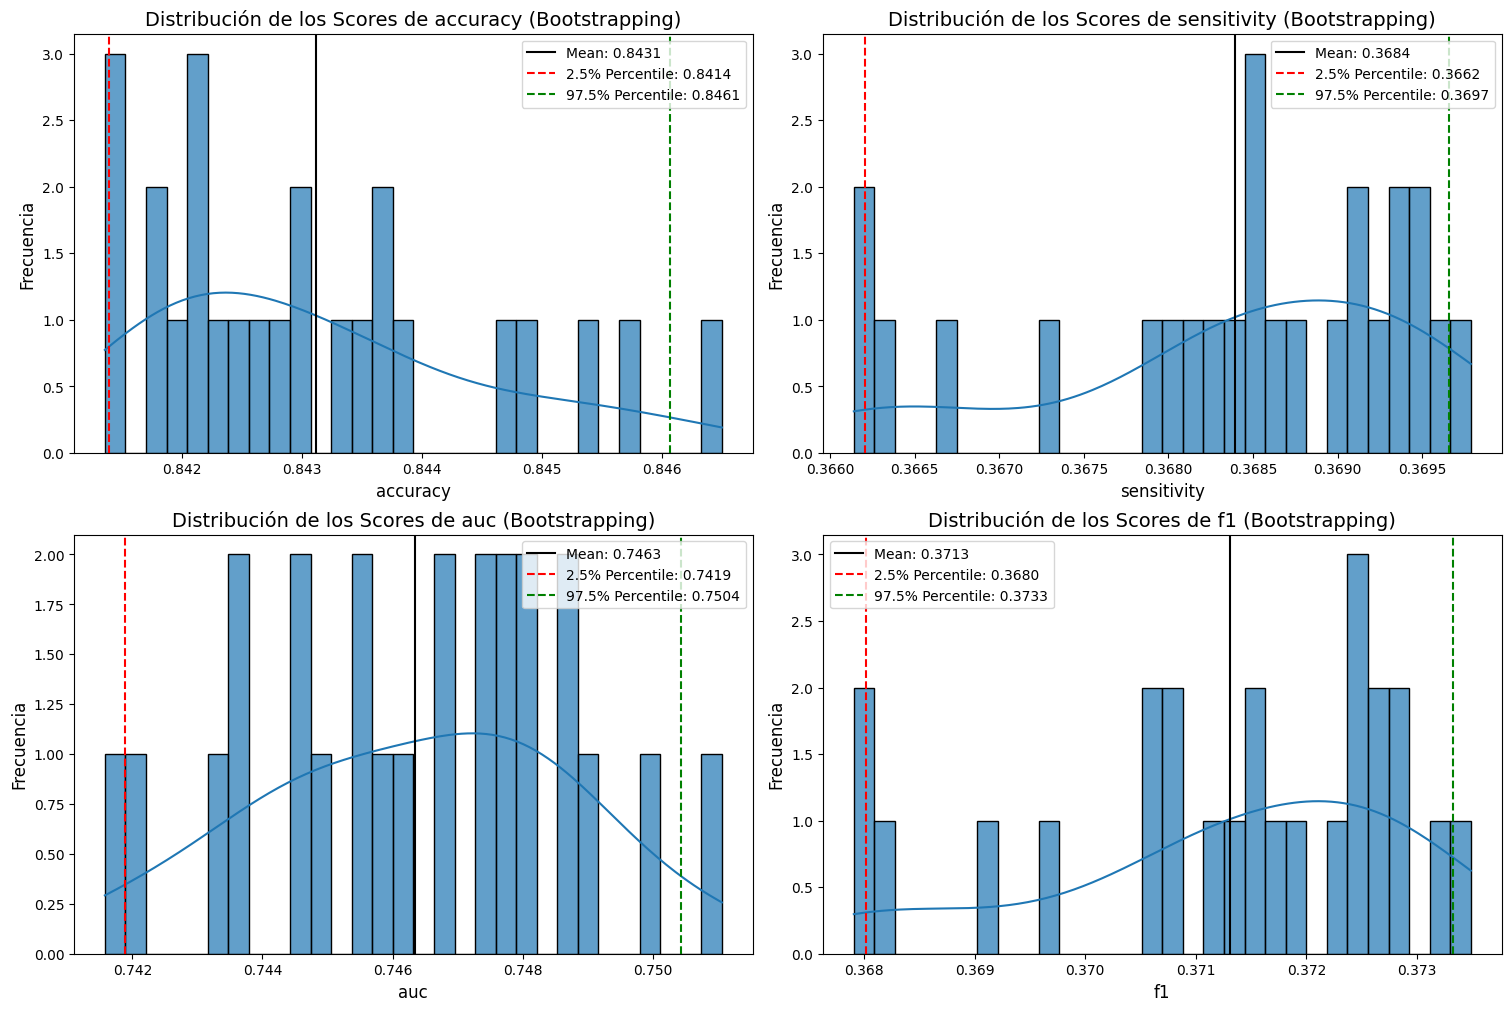

In [215]:
graph_bootstrap_ci_multimetric(models['Random Forest']['metrics'],['accuracy', 'sensitivity', 'auc', 'f1'],models['Random Forest']['ci_results'])

#### Decision Tree

In [174]:
metrics_df, ci_results = get_bootstrap_metrics_ci(n_iterations, sample_size, X_test, y_test, dtc ,training=False)
models['Decision Tree'] = {'metrics':metrics_df,'ci_results':ci_results} 

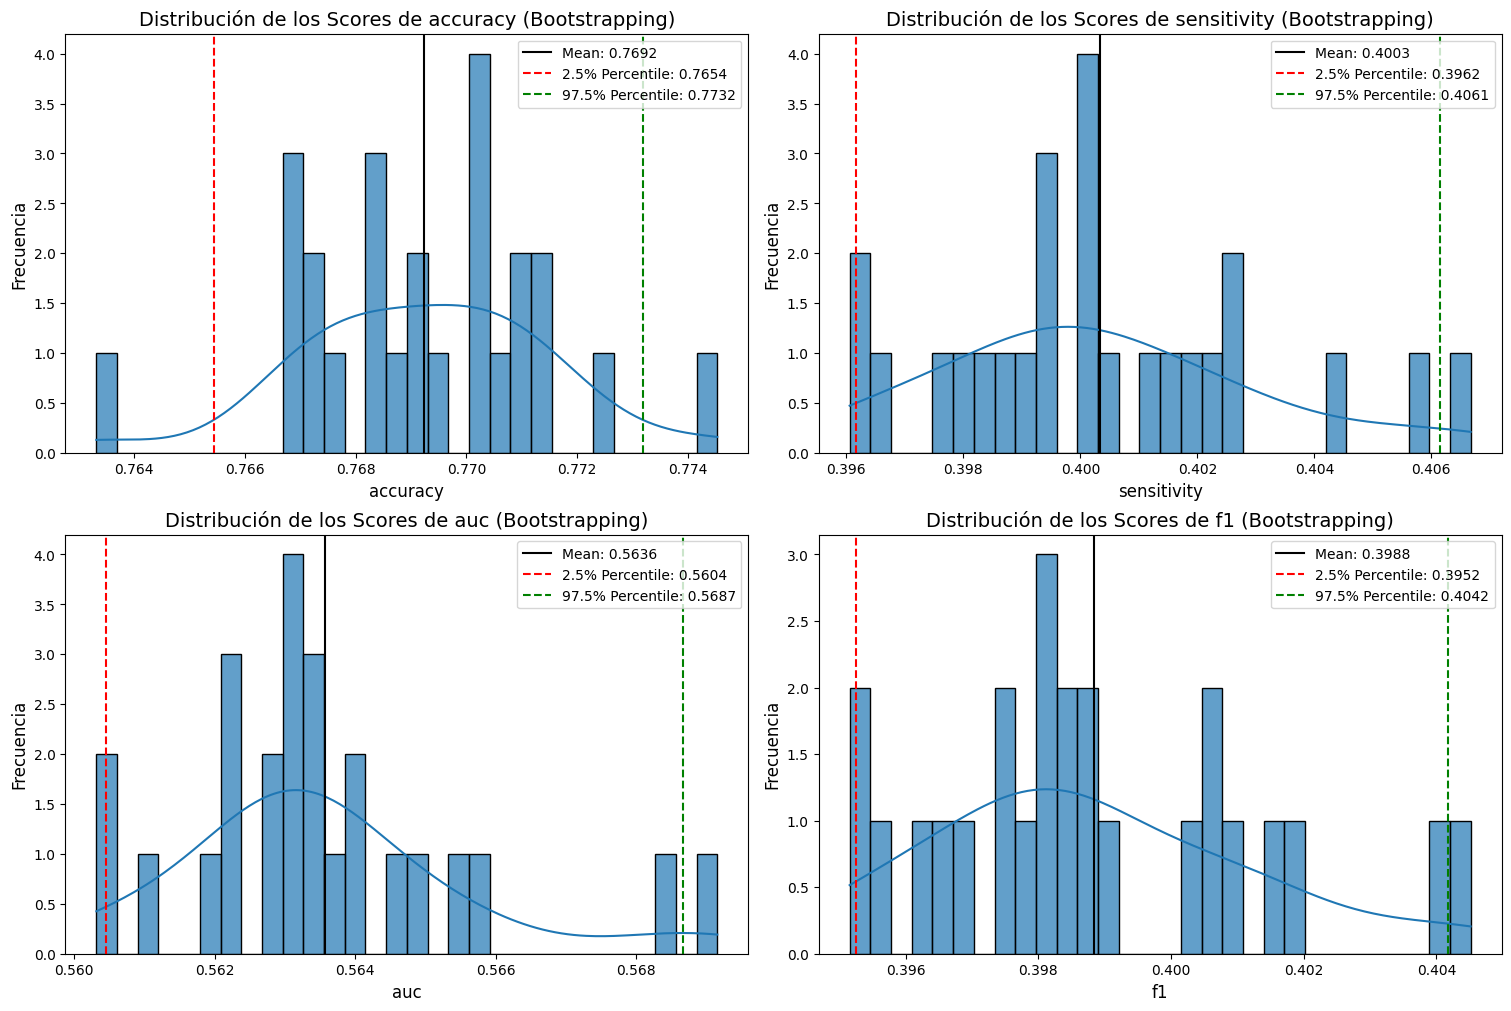

In [193]:
graph_bootstrap_ci_multimetric(models['Decision Tree']['metrics'],['accuracy', 'sensitivity', 'auc', 'f1'],models['Decision Tree']['ci_results'])

#### SVM

#### Neural Network - Multilayer Perceptron

In [197]:
metrics_df, ci_results = get_bootstrap_metrics_ci(n_iterations, sample_size, X_test, y_test, mp ,training=False)
models['NN'] = {'metrics':metrics_df,'ci_results':ci_results} 

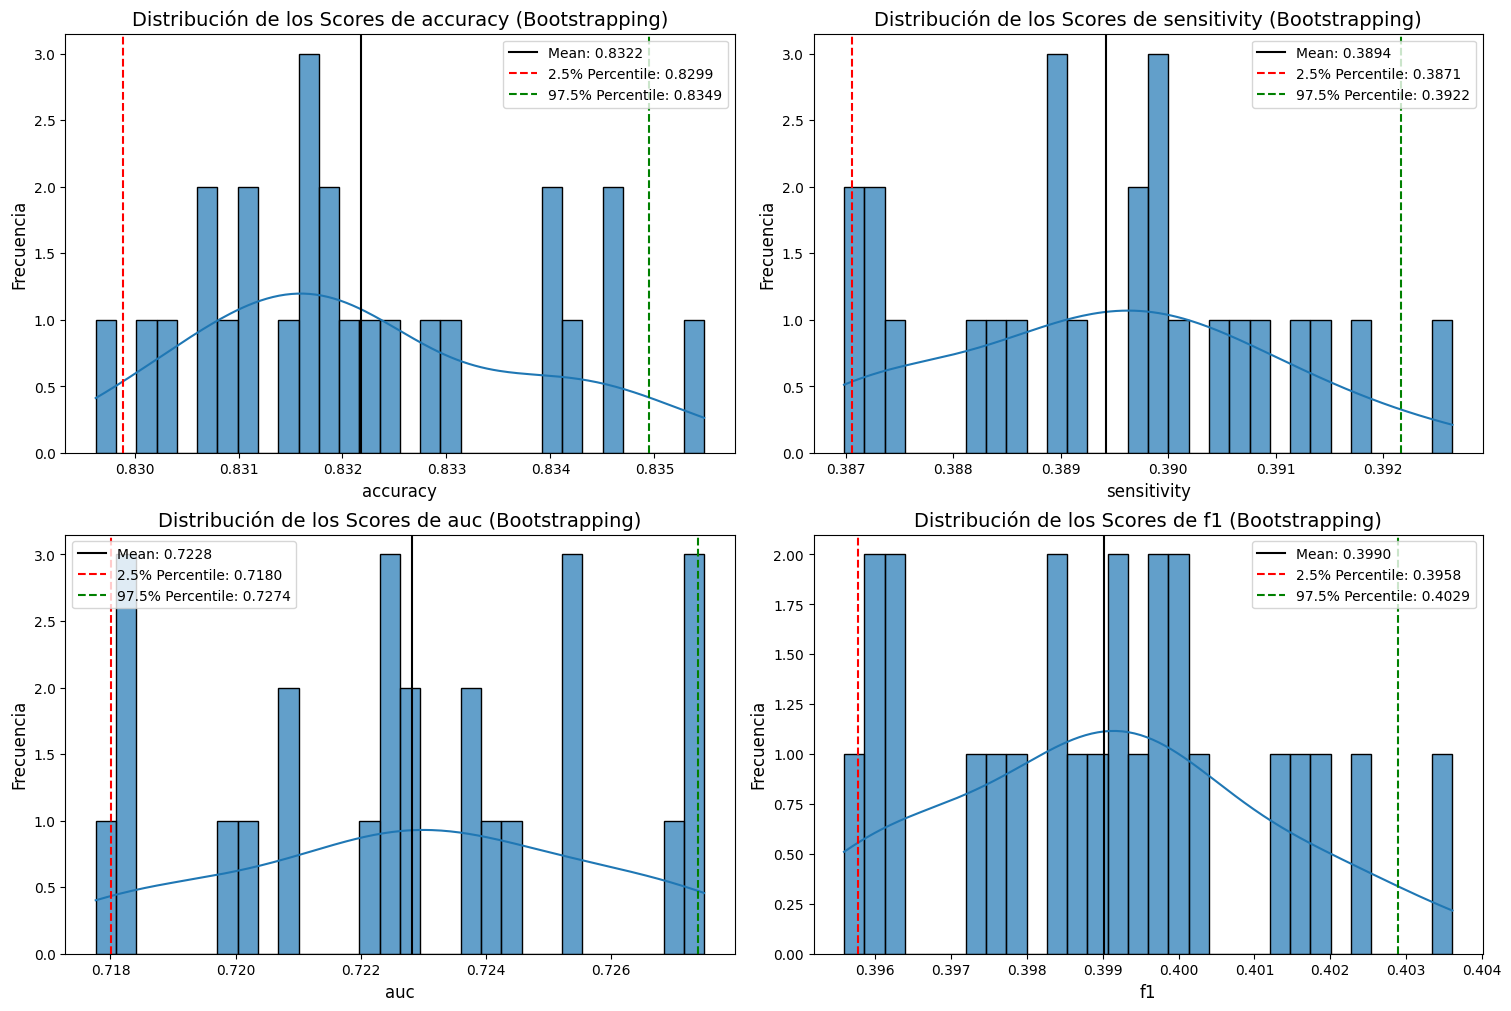

In [198]:
graph_bootstrap_ci_multimetric(models['NN']['metrics'],['accuracy', 'sensitivity', 'auc', 'f1'],models['NN']['ci_results'])

#### LDA

In [108]:
metrics_df, ci_results = get_bootstrap_metrics_ci(n_iterations, sample_size, X_test, y_test, lda ,training=False)
models['LDA'] = {'metrics':metrics_df,'ci_results':ci_results} 

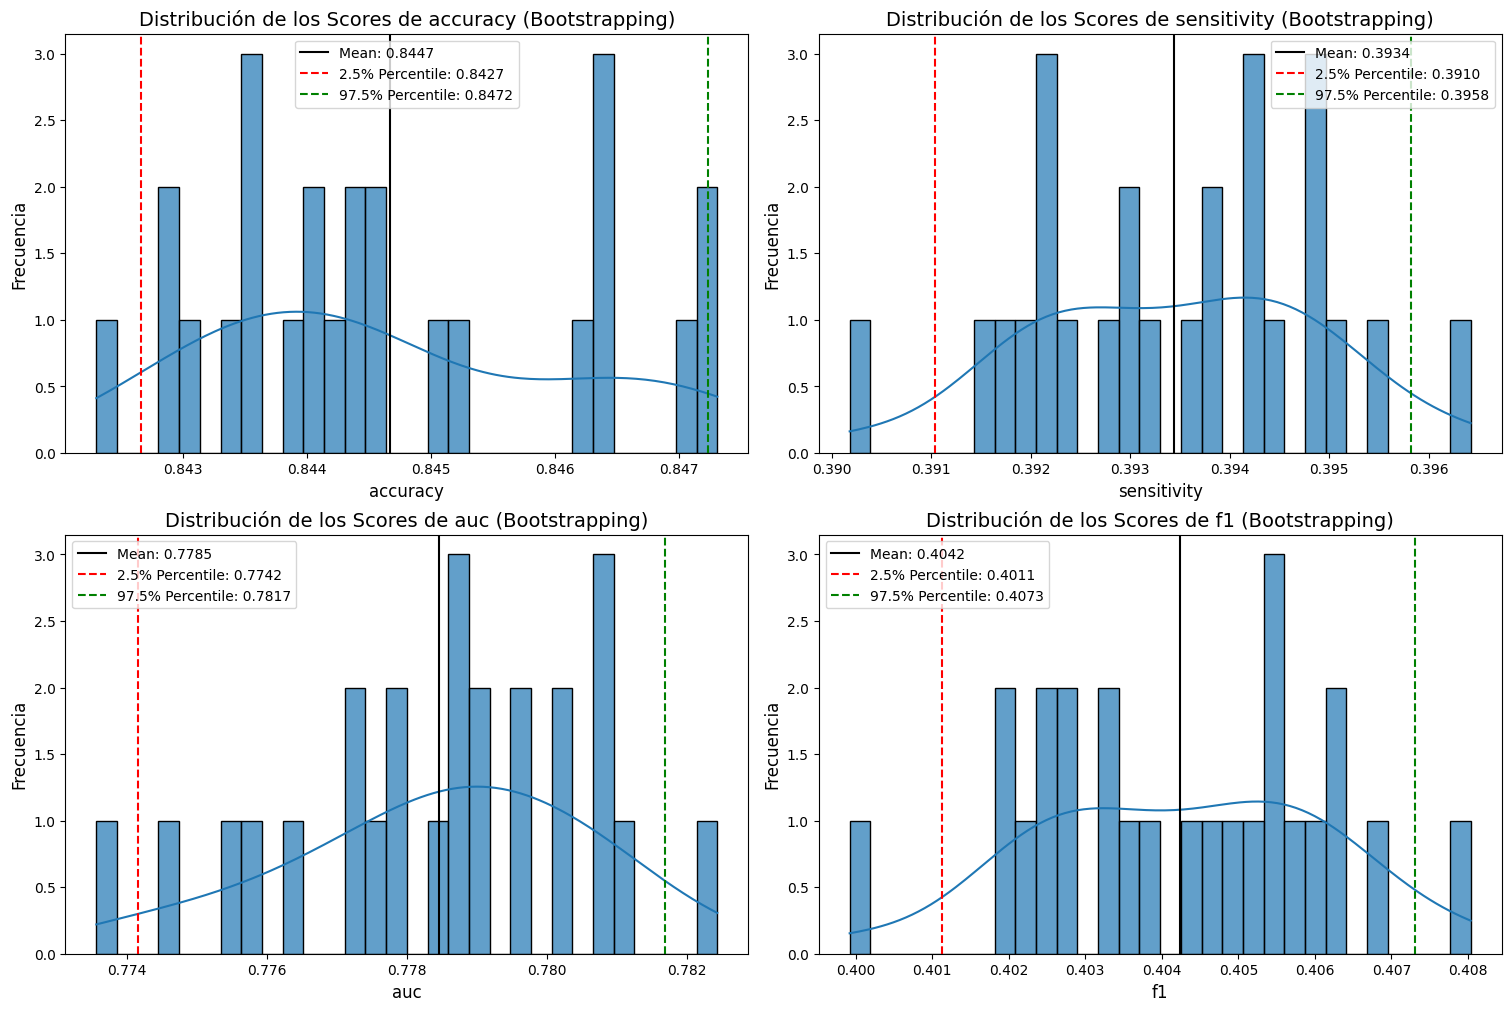

In [109]:
graph_bootstrap_ci_multimetric(models['LDA']['metrics'],['accuracy', 'sensitivity', 'auc', 'f1'],models['LDA']['ci_results'])

## Proceso de Comparación de Modelos Post-Entrenamiento y Test. 

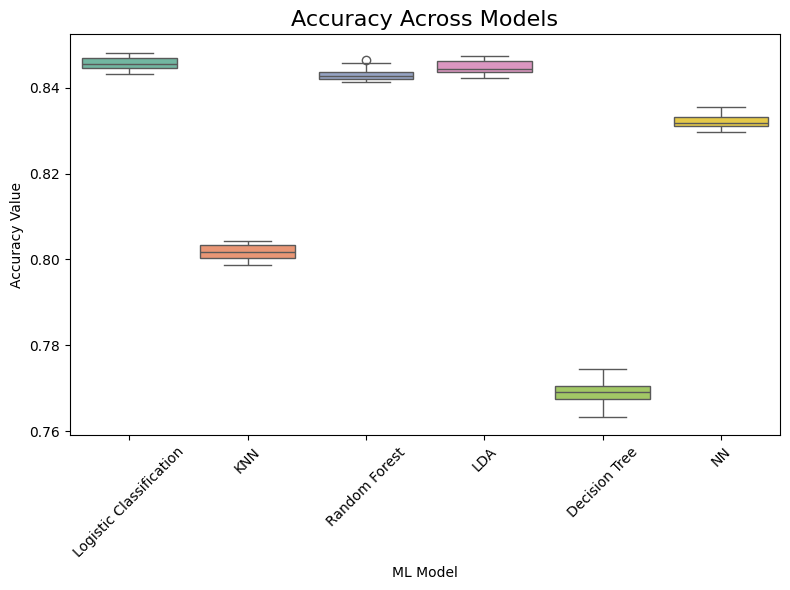

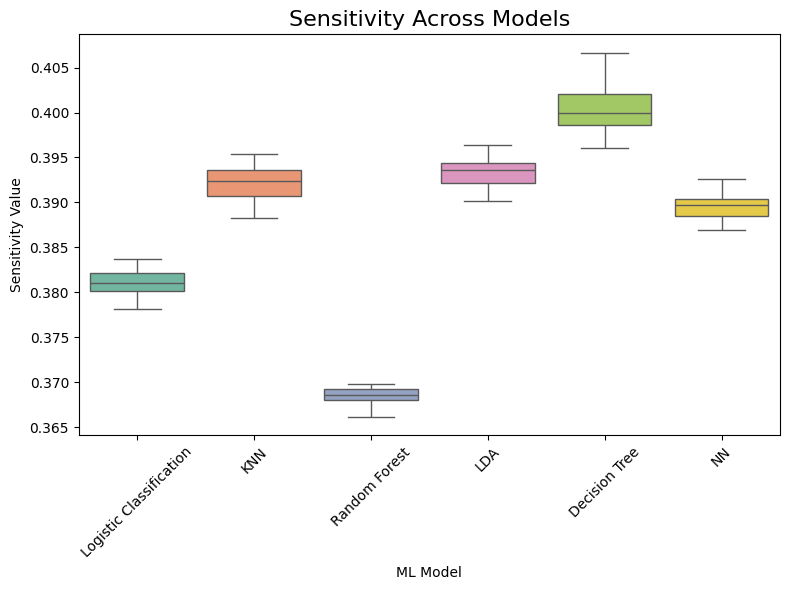

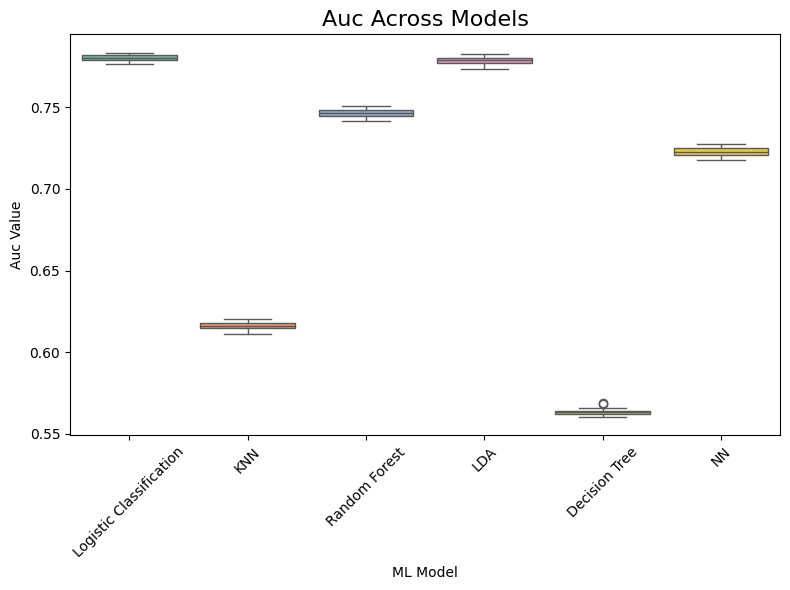

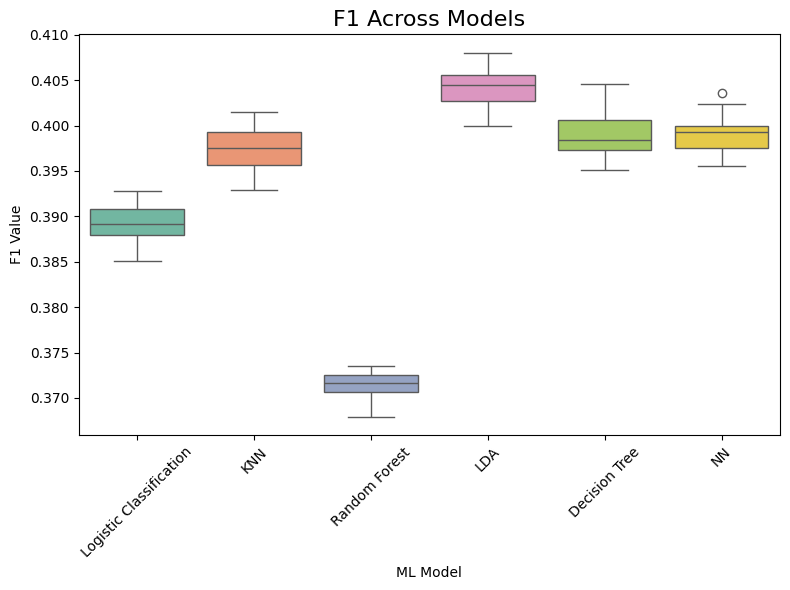

In [225]:
data = []
for model_name, model_data in models.items():
    df = model_data['metrics']
    long_df = df.melt(var_name='Metric', value_name='Value')  # Convert to long format
    long_df['Model'] = model_name  # Add model name
    data.append(long_df)

# Concatenate all data
plot_data = pd.concat(data)

# Create a separate plot for each metric
metrics = plot_data['Metric'].unique()
for metric in metrics:
    metric_data = plot_data[plot_data['Metric'] == metric]
    
    # Plot the boxplot for this metric
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=metric_data, x='Model', y='Value',hue='Model',palette='Set2')
    plt.title(f'{metric.capitalize()} Across Models', fontsize=16)
    plt.ylabel(f'{metric.capitalize()} Value')
    plt.xlabel('ML Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Kruskal Wallis Test 

In [219]:
from scipy.stats import kruskal

In [221]:
# Step 1: Calculate the mean for each metric-model combination
mean_df = plot_data.groupby(['Metric', 'Model'], as_index=False)['Value'].mean()

# Initialize dictionary to store results
kruskal_results = {}

# List unique metrics in the dataframe
metrics_to_test = mean_df['Metric'].unique()

# Perform Kruskal-Wallis Test for each metric
for metric in metrics_to_test:
    # Filter data for the current metric
    metric_data = mean_df[mean_df['Metric'] == metric]

    # Group mean metric values by model
    groups = [metric_data.loc[metric_data['Model'] == model, 'Value'] for model in metric_data['Model'].unique()]
    
    # Perform Kruskal-Wallis test
    stat, p_value = kruskal(*groups)
    kruskal_results[metric] = (stat, p_value)

# Display Results
print("Kruskal-Wallis Test Results (Using Mean Values):")
for metric, (stat, p_value) in kruskal_results.items():
    print(f"Metric: {metric}")
    print(f"  H-statistic: {stat:.2f}")
    print(f"  p-value: {p_value:.5f}")
    if p_value < 0.0001:
        print("  Significant difference detected among models!")
    else:
        print("  No significant difference detected among models.")

Kruskal-Wallis Test Results (Using Mean Values):
Metric: accuracy
  H-statistic: 5.00
  p-value: 0.41588
  No significant difference detected among models.
Metric: auc
  H-statistic: 5.00
  p-value: 0.41588
  No significant difference detected among models.
Metric: f1
  H-statistic: 5.00
  p-value: 0.41588
  No significant difference detected among models.
Metric: sensitivity
  H-statistic: 5.00
  p-value: 0.41588
  No significant difference detected among models.


In [218]:
plot_data

,Metric,Value,Model
0,accuracy,0.845986,Logistic Classification
1,accuracy,0.845845,Logistic Classification
2,accuracy,0.844661,Logistic Classification
3,accuracy,0.845762,Logistic Classification
4,accuracy,0.847900,Logistic Classification
...,...,...,...
95,f1,0.398664,NN
96,f1,0.397361,NN
97,f1,0.396263,NN
98,f1,0.398364,NN
